In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch, copy
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
import os
import numpy as np

SEED = 12345
DIGITS_TO_KEEP = [0, 4, 3]        # keep only these digits

# ---- Imbalance controls ----
N_PER_DIGIT_TOTAL = 400           # total samples per digit (wbflag=0 + wbflag=1)
FLAG1_RATIO = 0.30                # fraction of wbflag=1 (inverted) per digit (e.g., 0.2 -> 20%)

in_dir  = "datasets/MNIST/MNIST_subset"
out_dir = f"datasets/MNIST/MNIST_subset_{'_'.join(map(str, DIGITS_TO_KEEP))}_" \
          f"{len(DIGITS_TO_KEEP)*N_PER_DIGIT_TOTAL}_imb{int(FLAG1_RATIO*100)}"
os.makedirs(out_dir, exist_ok=True)

X_full = np.load(os.path.join(in_dir, "MNIST_train_wbX.npy"))     # (N,784) or (N,28,28)
digits = np.load(os.path.join(in_dir, "MNIST_train_digits.npy"))
wbflag = np.load(os.path.join(in_dir, "MNIST_train_wbflag.npy"))

rng = np.random.default_rng(SEED)
selected_indices = []

# precompute target counts per flag
target_n1 = int(round(N_PER_DIGIT_TOTAL * FLAG1_RATIO))     # wbflag=1
target_n0 = N_PER_DIGIT_TOTAL - target_n1                   # wbflag=0

for d in DIGITS_TO_KEEP:
    picks_for_d = []

    for f, target_n in [(0, target_n0), (1, target_n1)]:
        mask = (digits == d) & (wbflag == f)
        idxs = np.where(mask)[0]
        rng.shuffle(idxs)

        if len(idxs) < target_n:
            print(f"[WARN] digit={d}, wbflag={f}: requested {target_n}, "
                  f"but only {len(idxs)} available. Taking all available.")
        take = min(len(idxs), target_n)
        picks_for_d.extend(idxs[:take])

    if len(picks_for_d) < N_PER_DIGIT_TOTAL:
        need = N_PER_DIGIT_TOTAL - len(picks_for_d)
        # try topping up from whichever flag still has remaining samples
        for f in (0, 1):
            if need == 0: break
            mask = (digits == d) & (wbflag == f)
            pool = np.setdiff1d(np.where(mask)[0], np.array(picks_for_d), assume_unique=False)
            rng.shuffle(pool)
            extra = min(need, len(pool))
            if extra > 0:
                picks_for_d.extend(pool[:extra])
                need -= extra

    rng.shuffle(picks_for_d)
    selected_indices.extend(picks_for_d[:N_PER_DIGIT_TOTAL])  # enforce per-digit cap

selected_indices = np.array(selected_indices)
rng.shuffle(selected_indices)

digits_sub = digits[selected_indices]         # true digits, e.g., {0,3,4}
wbflag_sub = wbflag[selected_indices]         # sensitive flag {0 (orig), 1 (inverted)}
X_sub_full = X_full[selected_indices]         # images

# group = true digit (kept for analysis if needed)
group_sub = digits_sub.copy()

np.save(os.path.join(out_dir, "digits.npy"),  digits_sub)
np.save(os.path.join(out_dir, "wbflag.npy"),  wbflag_sub)
np.save(os.path.join(out_dir, "group.npy"),   group_sub)
np.save(os.path.join(out_dir, "indices.npy"), selected_indices)
np.save(os.path.join(out_dir, "wbX.npy"),     X_sub_full)

# Flatten if needed
if X_sub_full.ndim == 3:
    X_points = X_sub_full.reshape(X_sub_full.shape[0], -1).astype(np.float32)
else:
    X_points = X_sub_full.astype(np.float32)

# y_raw: original labels in DIGITS_TO_KEEP
y_raw = digits_sub.astype(np.int64)

# y: remap to {0,1,2} for CE if you ever need it
unique_labels = np.array(sorted(np.unique(y_raw)))  # e.g., [0,3,4]
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
y = np.vectorize(label_to_idx.get)(y_raw).astype(np.int64)

np.save(os.path.join(out_dir, "X.npy"),      X_points)
np.save(os.path.join(out_dir, "y_raw.npy"),  y_raw)
np.save(os.path.join(out_dir, "y.npy"),      y)

# Quick counts
print(f"\nTarget per digit: wbflag=0 -> {target_n0}, wbflag=1 -> {target_n1} "
      f"(total {N_PER_DIGIT_TOTAL}, ratio flag1={FLAG1_RATIO:.2f})")

for d in DIGITS_TO_KEEP:
    for f in (0, 1):
        c = np.sum((digits_sub == d) & (wbflag_sub == f))
        print(f"(digit={d}, wbflag={f}): {c}")

print("\nRemapped classes (0,1,2):")
for k, lab in enumerate(unique_labels):
    print(f"class {k} (digit {lab}): {(y==k).sum()}")

print("\nShapes:")
print("X_points:", X_points.shape, "| y_raw:", y_raw.shape, "| y:", y.shape)



Target per digit: wbflag=0 -> 280, wbflag=1 -> 120 (total 400, ratio flag1=0.30)
(digit=0, wbflag=0): 280
(digit=0, wbflag=1): 120
(digit=4, wbflag=0): 280
(digit=4, wbflag=1): 120
(digit=3, wbflag=0): 280
(digit=3, wbflag=1): 120

Remapped classes (0,1,2):
class 0 (digit 0): 400
class 1 (digit 3): 400
class 2 (digit 4): 400

Shapes:
X_points: (1200, 784) | y_raw: (1200,) | y: (1200,)


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.set_device(device)

print(f"Using device: {device}")


Using device: cpu


In [9]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_subset_with_wbflag(subset_dir, batch_size=256, shuffle=True):
    X = np.load(os.path.join(subset_dir, "X.npy")).astype(np.float32)     # (N, D)
    y = np.load(os.path.join(subset_dir, "y.npy")).astype(np.int64)       # (N,)
    S = np.load(os.path.join(subset_dir, "wbflag.npy")).astype(np.int64)  # (N,) 0=orig,1=inv
    assert len(X) == len(y) == len(S)

    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    S_t = torch.tensor(S, dtype=torch.long)

    ds = TensorDataset(X_t, y_t, S_t)  
    dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    input_dim = X.shape[1]
    return dl, input_dim, X, y, S

dataloader_wb, input_dim_from_loader, X_np, y_np, S_np = load_subset_with_wbflag(out_dir, batch_size=256, shuffle=True)
print("input_dim_from_loader:", input_dim_from_loader, "| dataset size:", len(X_np))


input_dim_from_loader: 784 | dataset size: 1200


In [13]:
class Autoencoder(nn.Module):
    """Plain AE: encoder -> decoder (no classifier head)."""
    def __init__(self, input_dim: int, latent_dim: int, negative_slope: float = 0.01):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),  nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 2000),       nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, latent_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2000), nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),         nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [15]:
def pretrain_autoencoder(dataloader, input_dim, latent_dim, device, epochs=30, lr=1e-3):
    ae = Autoencoder(input_dim, latent_dim).to(device)
    opt = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(epochs):
        total = 0
        nobs = 0
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                xb = batch[0]
            else:
                xb = batch
            xb = xb.to(device).float()

            opt.zero_grad(set_to_none=True)
            x_hat, _ = ae(xb)
            loss = loss_fn(x_hat, xb)
            loss.backward()
            opt.step()

            bs = xb.size(0)
            total += loss.item() * bs
            nobs  += bs
        print(f"Pretrain epoch {ep+1}/{epochs} | loss={total/nobs:.6f}")
    return ae


In [40]:
@torch.no_grad()
def init_kmeans_centers_from_latent(ae, dataloader, device, k: int):
    """Run KMeans on current latent to initialize centers."""
    ae.eval()
    Z = []
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)
        Z.append(z.cpu())
    Z = torch.cat(Z, dim=0).numpy()
    km = KMeans(n_clusters=k, n_init=3, random_state=0).fit(Z)
    centers = torch.tensor(km.cluster_centers_, dtype=torch.float32, device=device, requires_grad=True)
    return torch.nn.Parameter(centers)

In [17]:
@torch.no_grad()
def torch_kmeans_cost_full_stream(ae, centers, dataloader, device, reduce: str = "mean"):

    ae.eval()
    centers = centers.to(device)

    total, nobs = 0.0, 0
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)                           # [B, D]
        d2 = torch.cdist(z, centers).pow(2)     # [B, K]
        mins = d2.min(dim=1).values             # [B,]

        if reduce == "sum":
            total += mins.sum().item()
        else:  # 'mean' -> θα επιστρέψουμε global mean
            total += mins.sum().item()
            nobs  += mins.numel()

    if reduce == "sum":
        return total
    else:
        loss = total / max(1, nobs)
        return loss


In [19]:
@torch.no_grad()
def torch_kmeans_cost_full(ae, centers, dataloader, device):
    """(1/N) * sum_i min_j ||z_i - mu_j||^2 on the whole dataset (for reporting)."""
    ae.eval()
    Z = []
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)
        Z.append(z)
    Z = torch.cat(Z, dim=0)
    d2 = torch.cdist(Z, centers).pow(2)
    return d2.min(dim=1).values.mean().item()

In [38]:
@torch.enable_grad()
def social_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Social Fair objective (dataset-level; hard partition):
      Φ_social = max{ Δ(C, U∩A)/|A|,  Δ(C, U∩B)/|B| },
    where Δ(C, U∩A) = sum_j sum_{x∈U_j∩A} ||z - c_j||^2.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        d2 = torch.cdist(z, centers).pow(2)     # (B,K)
        a  = d2.argmin(dim=1)                   # (B,)
        d2_assigned = (z - centers[a]).pow(2).sum(dim=1)  # (B,)

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_assigned[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_assigned[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    social = torch.maximum(muA, muB)  # hard max
    return social, muA, muB

In [23]:
@torch.enable_grad()
def separation_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Separation Fair objective (dataset-level):
      Φ_sep = min{ E_A[d^2_bisector], E_B[d^2_bisector] },
    where d^2_bisector is squared distance of z to the bisector between its
    nearest and 2nd-nearest centers.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        d2 = torch.cdist(z, centers).pow(2)          
        m1_idx = d2.argmin(dim=1)
        d2_mask = d2.scatter(1, m1_idx.unsqueeze(1), float('inf'))
        m2_idx = d2_mask.argmin(dim=1)

        m1 = centers[m1_idx]
        m2 = centers[m2_idx]
        m  = 0.5 * (m1 + m2)
        v  = m2 - m1
        vn = torch.clamp(torch.linalg.norm(v, dim=1, keepdim=True), min=1e-12)
        vhat = v / vn
        s  = ((z - m) * vhat).sum(dim=1)             
        d2_hp = s * s

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_hp[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_hp[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    sep = torch.minimum(muA, muB)  # hard min
    return sep, muA, muB

In [25]:
def train_deepclust_unified(
    ae, dataloader, device, input_dim, latent_dim, k=3,
    epochs=50, lr=1e-3,
    alpha=0.1,        
    beta=1.0,        
    gamma_social=1.0, 
    gamma_sep=1.0,    
    clip_grad=5.0
):
    ae = ae.to(device)
    mse = nn.MSELoss()

    centers = init_kmeans_centers_from_latent(ae, dataloader, device, k)

    opt = optim.AdamW(
        [{"params": ae.parameters(), "lr": lr},
         {"params": [centers],       "lr": lr * 0.3}],
        weight_decay=1e-4
    )

    history = {
        "total": [], "rec": [], "cmp": [],
        "social": [], "sep": [],
        "muA_social": [], "muB_social": [],
        "muA_sep": [],    "muB_sep": []
    }

    for ep in range(epochs):
        # ---------- Phase 1: per-batch recon + compactness ----------
        ae.train()
        tot = rec_tot = cmp_tot = 0.0
        nobs = 0

        for batch in dataloader:
            xb = batch[0].to(device).float()

            x_hat, z = ae(xb)

            # reconstruction (input space)
            rec_loss = mse(x_hat, xb)

            # compactness 
            d2 = torch.cdist(z, centers).pow(2)
            min_d2 = d2.min(dim=1).values
            cmp_loss = min_d2.mean()

            loss_phase1 = alpha * rec_loss + beta * cmp_loss

            opt.zero_grad(set_to_none=True)
            loss_phase1.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
            opt.step()

            bs = xb.size(0)
            nobs    += bs
            rec_tot += rec_loss.item() * bs
            cmp_tot += cmp_loss.item() * bs
            tot     += loss_phase1.item() * bs

        rec_epoch = rec_tot / nobs
        cmp_epoch = cmp_tot / nobs
        total_epoch = tot / nobs

        # ---------- Phase 2: FULL-dataset fairness step ----------
        opt.zero_grad(set_to_none=True)

        social_term, muA_soc, muB_soc = social_fair_dataset(ae, centers, dataloader, device)
        sep_term,    muA_sep, muB_sep = separation_fair_dataset(ae, centers, dataloader, device)

        fairness_loss = gamma_social * social_term - gamma_sep * sep_term
        fairness_loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
        opt.step()

        # ---------- logging ----------
        history["total"].append(total_epoch + fairness_loss.item())
        history["rec"].append(rec_epoch)
        history["cmp"].append(cmp_epoch)
        history["social"].append(social_term.item())
        history["sep"].append(sep_term.item())
        history["muA_social"].append(muA_soc.item())
        history["muB_social"].append(muB_soc.item())
        history["muA_sep"].append(muA_sep.item())
        history["muB_sep"].append(muB_sep.item())

        print(f"[{ep+1:02d}/{epochs}] "
              f"Rec={rec_epoch:.5f} | Cmp={cmp_epoch:.5f} | "
              f"Social(max)={social_term.item():.5f} | Sep(min)={sep_term.item():.5f} | "
              f"μA_social={muA_soc.item():.5f} μB_social={muB_soc.item():.5f} | "
              f"μA_seperation={muA_sep.item():.5f} μB_seperation={muB_sep.item():.5f}")

    return ae, centers, history

In [33]:
def run_lambda_seed_grid(
    ae_pretrained,              
    dataloader_wb,              
    device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=1e-3,
    alpha=0.1,
    beta=1.0,
    lambda_list=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    seeds=range(10),
    save_dir="centroids_deep",
    save_centers_files=True,
    collect_decoded_centers=True,   
):
    min_fair_dict = {lam: [] for lam in lambda_list}
    max_fair_dict = {lam: [] for lam in lambda_list}
    seperation_fairness_gaps  = {lam: [] for lam in lambda_list}
    social_fairness_gaps  = {lam: [] for lam in lambda_list}
    kmeans_costs   = {lam: [] for lam in lambda_list}
    recon_costs    = {lam: [] for lam in lambda_list}
    compact_costs  = {lam: [] for lam in lambda_list}

    first_batch = next(iter(dataloader_wb))
    X_first = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
    D = X_first.shape[1]

    decoded_centers = None
    if collect_decoded_centers:
        L = len(lambda_list); S = len(list(seeds))
        decoded_centers = np.zeros((L, S, k, D), dtype=np.float32)

    pretrained_state = copy.deepcopy(ae_pretrained.state_dict())

    for li, lam in enumerate(lambda_list):
        print(f"\n=== λ (gamma) = {lam} ===")
        for si, seed in enumerate(seeds):
            print(f"  -> seed {seed}")
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

            ae = copy.deepcopy(ae_pretrained).to(device)
            ae.load_state_dict(pretrained_state)

            ae, centers, history = train_deepclust_unified(
                ae, dataloader_wb, device,input_dim=input_dim, 
                latent_dim=latent_dim, k=k,
                lr=lr, epochs=epochs,
                alpha=alpha, beta=beta, gamma_social=lam/2,gamma_sep=-lam/2
            )
            kmeans_cost = torch_kmeans_cost_full_stream(ae, centers, dataloader_wb, device,reduce="sum")
            minFair,cfdA, cfdB = separation_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            maxFair,muA,muB= social_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            seperation_gap = abs(cfdA - cfdB)
            social_gap = abs(muA - muB)

            kmeans_costs[lam].append(kmeans_cost)
            min_fair_dict[lam].append(minFair)
            max_fair_dict[lam].append(maxFair)
            seperation_fairness_gaps[lam].append(seperation_gap)
            social_fairness_gaps[lam].append(social_gap)
            recon_costs[lam].append(history["rec"][-1])
            compact_costs[lam].append(history["cmp"][-1])

    results = {
        "min_fair": min_fair_dict,
        "max_fair": max_fair_dict,
        "seperation_fair_gap": seperation_fairness_gaps,
        "social_fair_gap": social_fairness_gaps,
        "kmeans": kmeans_costs,
        "rec": recon_costs,
        "cmp": compact_costs
    }
    return results, list(lambda_list)


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_batch = next(iter(dataloader_wb))
X0 = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
input_dim = X0.shape[1]

latent_dim = 20
k = 3
ae = pretrain_autoencoder(dataloader_wb, input_dim, latent_dim=20, device=device, epochs=50)

Pretrain epoch 1/50 | loss=0.272026
Pretrain epoch 2/50 | loss=0.116802
Pretrain epoch 3/50 | loss=0.098428
Pretrain epoch 4/50 | loss=0.078909
Pretrain epoch 5/50 | loss=0.072289
Pretrain epoch 6/50 | loss=0.071131
Pretrain epoch 7/50 | loss=0.069785
Pretrain epoch 8/50 | loss=0.068753
Pretrain epoch 9/50 | loss=0.067712
Pretrain epoch 10/50 | loss=0.066596
Pretrain epoch 11/50 | loss=0.065805
Pretrain epoch 12/50 | loss=0.064969
Pretrain epoch 13/50 | loss=0.064655
Pretrain epoch 14/50 | loss=0.063909
Pretrain epoch 15/50 | loss=0.062829
Pretrain epoch 16/50 | loss=0.061941
Pretrain epoch 17/50 | loss=0.061065
Pretrain epoch 18/50 | loss=0.059832
Pretrain epoch 19/50 | loss=0.058802
Pretrain epoch 20/50 | loss=0.057927
Pretrain epoch 21/50 | loss=0.057028
Pretrain epoch 22/50 | loss=0.056548
Pretrain epoch 23/50 | loss=0.055508
Pretrain epoch 24/50 | loss=0.054684
Pretrain epoch 25/50 | loss=0.054001
Pretrain epoch 26/50 | loss=0.053606
Pretrain epoch 27/50 | loss=0.053249
Pretrain e

In [42]:
results, lambda2_list = run_lambda_seed_grid(
    ae_pretrained=ae,              
    dataloader_wb=dataloader_wb,   
    device=device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=1e-3,
    alpha=1.0,
    beta=1.0,
    lambda_list=[0.0,0.2,0.4,0.6,0.8,1.0],
    seeds=range(10),
    save_dir="centroids_deep_v1",
    save_centers_files=True,
    collect_decoded_centers=True,
)


=== λ (gamma) = 0.0 ===
  -> seed 0


C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08107 | Cmp=0.16619 | Social(max)=0.13284 | Sep(min)=1.40043 | μA_social=0.06831 μB_social=0.13284 | μA_seperation=3.39890 μB_seperation=1.40043
[03/50] Rec=0.07342 | Cmp=0.10044 | Social(max)=0.09990 | Sep(min)=1.52714 | μA_social=0.03368 μB_social=0.09990 | μA_seperation=3.44419 μB_seperation=1.52714
[04/50] Rec=0.06750 | Cmp=0.07448 | Social(max)=0.07015 | Sep(min)=1.50917 | μA_social=0.01108 μB_social=0.07015 | μA_seperation=3.30033 μB_seperation=1.50917
[05/50] Rec=0.06630 | Cmp=0.05448 | Social(max)=0.05789 | Sep(min)=1.49326 | μA_social=0.00376 μB_social=0.05789 | μA_seperation=3.23120 μB_seperation=1.49326
[06/50] Rec=0.06518 | Cmp=0.03788 | Social(max)=0.04128 | Sep(min)=1.54361 | μA_social=0.00565 μB_social=0.04128 | μA_seperation=3.23273 μB_seperation=1.54361
[07/50] Rec=0.06474 | Cmp=0.02891 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07578 | Cmp=0.15877 | Social(max)=0.12606 | Sep(min)=1.52624 | μA_social=0.09492 μB_social=0.12606 | μA_seperation=3.55768 μB_seperation=1.52624
[03/50] Rec=0.06885 | Cmp=0.09499 | Social(max)=0.09108 | Sep(min)=1.53983 | μA_social=0.03287 μB_social=0.09108 | μA_seperation=3.40892 μB_seperation=1.53983
[04/50] Rec=0.06673 | Cmp=0.06666 | Social(max)=0.07570 | Sep(min)=1.55999 | μA_social=0.01247 μB_social=0.07570 | μA_seperation=3.17612 μB_seperation=1.55999
[05/50] Rec=0.06571 | Cmp=0.05682 | Social(max)=0.05080 | Sep(min)=1.54839 | μA_social=0.00570 μB_social=0.05080 | μA_seperation=3.29190 μB_seperation=1.54839
[06/50] Rec=0.06502 | Cmp=0.04350 | Social(max)=0.04749 | Sep(min)=1.49817 | μA_social=0.00258 μB_social=0.04749 | μA_seperation=3.25890 μB_seperation=1.49817
[07/50] Rec=0.06408 | Cmp=0.02999 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21748 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21748 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.08033 | Cmp=0.15506 | Social(max)=0.12460 | Sep(min)=1.50755 | μA_social=0.04983 μB_social=0.12460 | μA_seperation=3.28012 μB_seperation=1.50755
[03/50] Rec=0.07302 | Cmp=0.08824 | Social(max)=0.09229 | Sep(min)=1.48465 | μA_social=0.02734 μB_social=0.09229 | μA_seperation=3.39743 μB_seperation=1.48465
[04/50] Rec=0.06779 | Cmp=0.05896 | Social(max)=0.06155 | Sep(min)=1.50240 | μA_social=0.01310 μB_social=0.06155 | μA_seperation=3.19841 μB_seperation=1.50240
[05/50] Rec=0.06630 | Cmp=0.04375 | Social(max)=0.04405 | Sep(min)=1.56656 | μA_social=0.00705 μB_social=0.04405 | μA_seperation=3.33290 μB_seperation=1.56656
[06/50] Rec=0.06500 | Cmp=0.03192 | Social(max)=0.03878 | Sep(min)=1.61119 | μA_social=0.00505 μB_social=0.03878 | μA_seperation=3.38030 μB_seperation=1.61119
[07/50] Rec=0.06526 | Cmp=0.03269 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30626 μB_seperation=1.35893
[02/50] Rec=0.08042 | Cmp=0.17962 | Social(max)=0.12838 | Sep(min)=1.60490 | μA_social=0.08536 μB_social=0.12838 | μA_seperation=3.21843 μB_seperation=1.60490
[03/50] Rec=0.07221 | Cmp=0.09374 | Social(max)=0.09359 | Sep(min)=1.41416 | μA_social=0.04560 μB_social=0.09359 | μA_seperation=3.55586 μB_seperation=1.41416
[04/50] Rec=0.06812 | Cmp=0.06811 | Social(max)=0.06635 | Sep(min)=1.59619 | μA_social=0.01911 μB_social=0.06635 | μA_seperation=3.27565 μB_seperation=1.59619
[05/50] Rec=0.06697 | Cmp=0.04949 | Social(max)=0.05138 | Sep(min)=1.54077 | μA_social=0.00687 μB_social=0.05138 | μA_seperation=3.25510 μB_seperation=1.54077
[06/50] Rec=0.06597 | Cmp=0.03846 | Social(max)=0.03942 | Sep(min)=1.58179 | μA_social=0.00305 μB_social=0.03942 | μA_seperation=3.34103 μB_seperation=1.58179
[07/50] Rec=0.06482 | Cmp=0.02991 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07513 | Cmp=0.15267 | Social(max)=0.13322 | Sep(min)=1.62527 | μA_social=0.02348 μB_social=0.13322 | μA_seperation=3.41600 μB_seperation=1.62527
[03/50] Rec=0.07034 | Cmp=0.09437 | Social(max)=0.10143 | Sep(min)=1.39550 | μA_social=0.01482 μB_social=0.10143 | μA_seperation=3.33611 μB_seperation=1.39550
[04/50] Rec=0.06655 | Cmp=0.06537 | Social(max)=0.07210 | Sep(min)=1.65703 | μA_social=0.00660 μB_social=0.07210 | μA_seperation=3.18801 μB_seperation=1.65703
[05/50] Rec=0.06546 | Cmp=0.05217 | Social(max)=0.05520 | Sep(min)=1.50029 | μA_social=0.00439 μB_social=0.05520 | μA_seperation=3.15887 μB_seperation=1.50029
[06/50] Rec=0.06524 | Cmp=0.03655 | Social(max)=0.04097 | Sep(min)=1.57064 | μA_social=0.00178 μB_social=0.04097 | μA_seperation=3.28155 μB_seperation=1.57064
[07/50] Rec=0.06544 | Cmp=0.02796 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08229 | Cmp=0.16672 | Social(max)=0.12731 | Sep(min)=1.59395 | μA_social=0.08037 μB_social=0.12731 | μA_seperation=3.40142 μB_seperation=1.59395
[03/50] Rec=0.07303 | Cmp=0.09793 | Social(max)=0.10270 | Sep(min)=1.44689 | μA_social=0.02882 μB_social=0.10270 | μA_seperation=3.44889 μB_seperation=1.44689
[04/50] Rec=0.06783 | Cmp=0.08132 | Social(max)=0.07231 | Sep(min)=1.54563 | μA_social=0.01169 μB_social=0.07231 | μA_seperation=3.27279 μB_seperation=1.54563
[05/50] Rec=0.06630 | Cmp=0.06356 | Social(max)=0.07706 | Sep(min)=1.56560 | μA_social=0.00289 μB_social=0.07706 | μA_seperation=3.31992 μB_seperation=1.56560
[06/50] Rec=0.06539 | Cmp=0.04228 | Social(max)=0.05011 | Sep(min)=1.48763 | μA_social=0.00219 μB_social=0.05011 | μA_seperation=3.30683 μB_seperation=1.48763
[07/50] Rec=0.06482 | Cmp=0.03043 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08539 | Cmp=0.16351 | Social(max)=0.12264 | Sep(min)=1.51799 | μA_social=0.06263 μB_social=0.12264 | μA_seperation=3.41857 μB_seperation=1.51799
[03/50] Rec=0.07530 | Cmp=0.09415 | Social(max)=0.09578 | Sep(min)=1.52165 | μA_social=0.01928 μB_social=0.09578 | μA_seperation=3.39740 μB_seperation=1.52165
[04/50] Rec=0.07168 | Cmp=0.07014 | Social(max)=0.06536 | Sep(min)=1.50695 | μA_social=0.01269 μB_social=0.06536 | μA_seperation=3.34786 μB_seperation=1.50695
[05/50] Rec=0.06712 | Cmp=0.05546 | Social(max)=0.06526 | Sep(min)=1.53116 | μA_social=0.00641 μB_social=0.06526 | μA_seperation=3.32686 μB_seperation=1.53116
[06/50] Rec=0.06618 | Cmp=0.04133 | Social(max)=0.03823 | Sep(min)=1.54102 | μA_social=0.00785 μB_social=0.03823 | μA_seperation=3.39803 μB_seperation=1.54102
[07/50] Rec=0.06459 | Cmp=0.02967 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02308 μB_seperation=1.34945
[02/50] Rec=0.07743 | Cmp=0.18406 | Social(max)=0.13227 | Sep(min)=1.62924 | μA_social=0.07645 μB_social=0.13227 | μA_seperation=3.32061 μB_seperation=1.62924
[03/50] Rec=0.07133 | Cmp=0.10352 | Social(max)=0.10440 | Sep(min)=1.40933 | μA_social=0.02841 μB_social=0.10440 | μA_seperation=3.25881 μB_seperation=1.40933
[04/50] Rec=0.06742 | Cmp=0.07978 | Social(max)=0.06780 | Sep(min)=1.55884 | μA_social=0.01081 μB_social=0.06780 | μA_seperation=3.13701 μB_seperation=1.55884
[05/50] Rec=0.06577 | Cmp=0.04991 | Social(max)=0.05052 | Sep(min)=1.47918 | μA_social=0.00743 μB_social=0.05052 | μA_seperation=3.27823 μB_seperation=1.47918
[06/50] Rec=0.06516 | Cmp=0.03511 | Social(max)=0.04423 | Sep(min)=1.46178 | μA_social=0.00526 μB_social=0.04423 | μA_seperation=3.40656 μB_seperation=1.46178
[07/50] Rec=0.06478 | Cmp=0.03109 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07898 | Cmp=0.17289 | Social(max)=0.14410 | Sep(min)=1.46463 | μA_social=0.05067 μB_social=0.14410 | μA_seperation=3.61132 μB_seperation=1.46463
[03/50] Rec=0.07175 | Cmp=0.09229 | Social(max)=0.09080 | Sep(min)=1.49205 | μA_social=0.01970 μB_social=0.09080 | μA_seperation=3.57673 μB_seperation=1.49205
[04/50] Rec=0.06891 | Cmp=0.07020 | Social(max)=0.08857 | Sep(min)=1.52123 | μA_social=0.00781 μB_social=0.08857 | μA_seperation=3.41978 μB_seperation=1.52123
[05/50] Rec=0.06653 | Cmp=0.05248 | Social(max)=0.06073 | Sep(min)=1.43790 | μA_social=0.00707 μB_social=0.06073 | μA_seperation=3.38471 μB_seperation=1.43790
[06/50] Rec=0.06630 | Cmp=0.03879 | Social(max)=0.04093 | Sep(min)=1.57937 | μA_social=0.00458 μB_social=0.04093 | μA_seperation=3.40437 μB_seperation=1.57937
[07/50] Rec=0.06535 | Cmp=0.02742 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.06939 | Cmp=0.15083 | Social(max)=0.12597 | Sep(min)=1.48678 | μA_social=0.02581 μB_social=0.12597 | μA_seperation=3.40822 μB_seperation=1.48678
[03/50] Rec=0.06765 | Cmp=0.09290 | Social(max)=0.09615 | Sep(min)=1.48330 | μA_social=0.01135 μB_social=0.09615 | μA_seperation=3.38834 μB_seperation=1.48330
[04/50] Rec=0.06584 | Cmp=0.06559 | Social(max)=0.06670 | Sep(min)=1.48097 | μA_social=0.00611 μB_social=0.06670 | μA_seperation=3.25823 μB_seperation=1.48097
[05/50] Rec=0.06486 | Cmp=0.04795 | Social(max)=0.04821 | Sep(min)=1.53337 | μA_social=0.00362 μB_social=0.04821 | μA_seperation=3.28308 μB_seperation=1.53337
[06/50] Rec=0.06464 | Cmp=0.03412 | Social(max)=0.03634 | Sep(min)=1.50476 | μA_social=0.00222 μB_social=0.03634 | μA_seperation=3.28947 μB_seperation=1.50476
[07/50] Rec=0.06446 | Cmp=0.02261 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08044 | Cmp=0.15977 | Social(max)=0.12899 | Sep(min)=1.53518 | μA_social=0.06889 μB_social=0.12899 | μA_seperation=3.40642 μB_seperation=1.53518
[03/50] Rec=0.07236 | Cmp=0.10191 | Social(max)=0.09765 | Sep(min)=1.54177 | μA_social=0.03344 μB_social=0.09765 | μA_seperation=3.40099 μB_seperation=1.54177
[04/50] Rec=0.06702 | Cmp=0.07122 | Social(max)=0.06727 | Sep(min)=1.58120 | μA_social=0.01092 μB_social=0.06727 | μA_seperation=3.22493 μB_seperation=1.58120
[05/50] Rec=0.06621 | Cmp=0.04948 | Social(max)=0.04928 | Sep(min)=1.51225 | μA_social=0.00451 μB_social=0.04928 | μA_seperation=3.18606 μB_seperation=1.51225
[06/50] Rec=0.06520 | Cmp=0.03378 | Social(max)=0.03527 | Sep(min)=1.56102 | μA_social=0.00435 μB_social=0.03527 | μA_seperation=3.27672 μB_seperation=1.56102
[07/50] Rec=0.06511 | Cmp=0.02682 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07584 | Cmp=0.16374 | Social(max)=0.13332 | Sep(min)=1.60435 | μA_social=0.09708 μB_social=0.13332 | μA_seperation=3.58110 μB_seperation=1.60435
[03/50] Rec=0.06970 | Cmp=0.09905 | Social(max)=0.09663 | Sep(min)=1.51072 | μA_social=0.03572 μB_social=0.09663 | μA_seperation=3.43019 μB_seperation=1.51072
[04/50] Rec=0.06796 | Cmp=0.07284 | Social(max)=0.07378 | Sep(min)=1.59557 | μA_social=0.01278 μB_social=0.07378 | μA_seperation=3.37188 μB_seperation=1.59557
[05/50] Rec=0.06557 | Cmp=0.05273 | Social(max)=0.05422 | Sep(min)=1.57202 | μA_social=0.00730 μB_social=0.05422 | μA_seperation=3.48265 μB_seperation=1.57202
[06/50] Rec=0.06461 | Cmp=0.03840 | Social(max)=0.04165 | Sep(min)=1.55651 | μA_social=0.00446 μB_social=0.04165 | μA_seperation=3.41545 μB_seperation=1.55651
[07/50] Rec=0.06440 | Cmp=0.02794 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21748 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21748 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.07942 | Cmp=0.15224 | Social(max)=0.12719 | Sep(min)=1.63949 | μA_social=0.04933 μB_social=0.12719 | μA_seperation=3.29043 μB_seperation=1.63949
[03/50] Rec=0.07210 | Cmp=0.08914 | Social(max)=0.09304 | Sep(min)=1.53683 | μA_social=0.02752 μB_social=0.09304 | μA_seperation=3.42259 μB_seperation=1.53683
[04/50] Rec=0.06751 | Cmp=0.06719 | Social(max)=0.07238 | Sep(min)=1.57494 | μA_social=0.01353 μB_social=0.07238 | μA_seperation=3.21577 μB_seperation=1.57494
[05/50] Rec=0.06573 | Cmp=0.05388 | Social(max)=0.05919 | Sep(min)=1.57774 | μA_social=0.00892 μB_social=0.05919 | μA_seperation=3.38766 μB_seperation=1.57774
[06/50] Rec=0.06487 | Cmp=0.04098 | Social(max)=0.04673 | Sep(min)=1.55411 | μA_social=0.01171 μB_social=0.04673 | μA_seperation=3.53157 μB_seperation=1.55411
[07/50] Rec=0.06496 | Cmp=0.03714 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30626 μB_seperation=1.35893
[02/50] Rec=0.07961 | Cmp=0.17824 | Social(max)=0.13143 | Sep(min)=1.70327 | μA_social=0.08570 μB_social=0.13143 | μA_seperation=3.22473 μB_seperation=1.70327
[03/50] Rec=0.07154 | Cmp=0.09221 | Social(max)=0.09263 | Sep(min)=1.45747 | μA_social=0.04675 μB_social=0.09263 | μA_seperation=3.56450 μB_seperation=1.45747
[04/50] Rec=0.06786 | Cmp=0.07520 | Social(max)=0.08156 | Sep(min)=1.64068 | μA_social=0.01985 μB_social=0.08156 | μA_seperation=3.31547 μB_seperation=1.64068
[05/50] Rec=0.06690 | Cmp=0.05492 | Social(max)=0.05429 | Sep(min)=1.55503 | μA_social=0.00734 μB_social=0.05429 | μA_seperation=3.30354 μB_seperation=1.55503
[06/50] Rec=0.06645 | Cmp=0.03985 | Social(max)=0.05067 | Sep(min)=1.52043 | μA_social=0.00408 μB_social=0.05067 | μA_seperation=3.37395 μB_seperation=1.52043
[07/50] Rec=0.06517 | Cmp=0.03315 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07460 | Cmp=0.15546 | Social(max)=0.13741 | Sep(min)=1.69813 | μA_social=0.02370 μB_social=0.13741 | μA_seperation=3.42022 μB_seperation=1.69813
[03/50] Rec=0.07010 | Cmp=0.09247 | Social(max)=0.09960 | Sep(min)=1.45689 | μA_social=0.01469 μB_social=0.09960 | μA_seperation=3.33772 μB_seperation=1.45689
[04/50] Rec=0.06686 | Cmp=0.06855 | Social(max)=0.07677 | Sep(min)=1.66721 | μA_social=0.00590 μB_social=0.07677 | μA_seperation=3.20753 μB_seperation=1.66721
[05/50] Rec=0.06558 | Cmp=0.05069 | Social(max)=0.05657 | Sep(min)=1.52660 | μA_social=0.00364 μB_social=0.05657 | μA_seperation=3.23448 μB_seperation=1.52660
[06/50] Rec=0.06528 | Cmp=0.03923 | Social(max)=0.04089 | Sep(min)=1.53458 | μA_social=0.00217 μB_social=0.04089 | μA_seperation=3.37546 μB_seperation=1.53458
[07/50] Rec=0.06484 | Cmp=0.03446 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08133 | Cmp=0.16703 | Social(max)=0.13075 | Sep(min)=1.64889 | μA_social=0.08195 μB_social=0.13075 | μA_seperation=3.41722 μB_seperation=1.64889
[03/50] Rec=0.07159 | Cmp=0.09535 | Social(max)=0.09355 | Sep(min)=1.48371 | μA_social=0.02969 μB_social=0.09355 | μA_seperation=3.46100 μB_seperation=1.48371
[04/50] Rec=0.06742 | Cmp=0.07247 | Social(max)=0.07929 | Sep(min)=1.55613 | μA_social=0.01463 μB_social=0.07929 | μA_seperation=3.36767 μB_seperation=1.55613
[05/50] Rec=0.06615 | Cmp=0.06428 | Social(max)=0.06189 | Sep(min)=1.55410 | μA_social=0.00731 μB_social=0.06189 | μA_seperation=3.48425 μB_seperation=1.55410
[06/50] Rec=0.06530 | Cmp=0.04155 | Social(max)=0.04026 | Sep(min)=1.54296 | μA_social=0.00369 μB_social=0.04026 | μA_seperation=3.38582 μB_seperation=1.54296
[07/50] Rec=0.06458 | Cmp=0.02984 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08465 | Cmp=0.16576 | Social(max)=0.12248 | Sep(min)=1.60293 | μA_social=0.06327 μB_social=0.12248 | μA_seperation=3.42532 μB_seperation=1.60293
[03/50] Rec=0.07504 | Cmp=0.09823 | Social(max)=0.09507 | Sep(min)=1.56290 | μA_social=0.01955 μB_social=0.09507 | μA_seperation=3.36964 μB_seperation=1.56290
[04/50] Rec=0.07169 | Cmp=0.06777 | Social(max)=0.07024 | Sep(min)=1.58966 | μA_social=0.01057 μB_social=0.07024 | μA_seperation=3.27091 μB_seperation=1.58966
[05/50] Rec=0.06744 | Cmp=0.05086 | Social(max)=0.05227 | Sep(min)=1.54381 | μA_social=0.00626 μB_social=0.05227 | μA_seperation=3.23206 μB_seperation=1.54381
[06/50] Rec=0.06588 | Cmp=0.04193 | Social(max)=0.04254 | Sep(min)=1.49464 | μA_social=0.00621 μB_social=0.04254 | μA_seperation=3.36192 μB_seperation=1.49464
[07/50] Rec=0.06527 | Cmp=0.03307 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02310 μB_seperation=1.34945
[02/50] Rec=0.07720 | Cmp=0.18708 | Social(max)=0.13444 | Sep(min)=1.66993 | μA_social=0.07615 μB_social=0.13444 | μA_seperation=3.33039 μB_seperation=1.66993
[03/50] Rec=0.07163 | Cmp=0.10508 | Social(max)=0.10077 | Sep(min)=1.46370 | μA_social=0.02980 μB_social=0.10077 | μA_seperation=3.23698 μB_seperation=1.46370
[04/50] Rec=0.06756 | Cmp=0.08090 | Social(max)=0.07148 | Sep(min)=1.56864 | μA_social=0.01041 μB_social=0.07148 | μA_seperation=3.15288 μB_seperation=1.56864
[05/50] Rec=0.06592 | Cmp=0.05098 | Social(max)=0.05364 | Sep(min)=1.55022 | μA_social=0.00774 μB_social=0.05364 | μA_seperation=3.29084 μB_seperation=1.55022
[06/50] Rec=0.06560 | Cmp=0.03961 | Social(max)=0.03998 | Sep(min)=1.49399 | μA_social=0.00547 μB_social=0.03998 | μA_seperation=3.42042 μB_seperation=1.49399
[07/50] Rec=0.06513 | Cmp=0.03092 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07753 | Cmp=0.16394 | Social(max)=0.13024 | Sep(min)=1.56907 | μA_social=0.05186 μB_social=0.13024 | μA_seperation=3.62519 μB_seperation=1.56907
[03/50] Rec=0.07078 | Cmp=0.08687 | Social(max)=0.09036 | Sep(min)=1.46760 | μA_social=0.02008 μB_social=0.09036 | μA_seperation=3.57990 μB_seperation=1.46760
[04/50] Rec=0.06833 | Cmp=0.06594 | Social(max)=0.07212 | Sep(min)=1.55589 | μA_social=0.00861 μB_social=0.07212 | μA_seperation=3.45896 μB_seperation=1.55589
[05/50] Rec=0.06608 | Cmp=0.04530 | Social(max)=0.04787 | Sep(min)=1.48992 | μA_social=0.00785 μB_social=0.04787 | μA_seperation=3.39181 μB_seperation=1.48992
[06/50] Rec=0.06554 | Cmp=0.03517 | Social(max)=0.03585 | Sep(min)=1.55063 | μA_social=0.00440 μB_social=0.03585 | μA_seperation=3.39485 μB_seperation=1.55063
[07/50] Rec=0.06538 | Cmp=0.02796 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.06914 | Cmp=0.14998 | Social(max)=0.12876 | Sep(min)=1.60397 | μA_social=0.02100 μB_social=0.12876 | μA_seperation=3.38907 μB_seperation=1.60397
[03/50] Rec=0.06716 | Cmp=0.09307 | Social(max)=0.09219 | Sep(min)=1.49954 | μA_social=0.01441 μB_social=0.09219 | μA_seperation=3.47265 μB_seperation=1.49954
[04/50] Rec=0.06642 | Cmp=0.06852 | Social(max)=0.06610 | Sep(min)=1.52454 | μA_social=0.00694 μB_social=0.06610 | μA_seperation=3.38295 μB_seperation=1.52454
[05/50] Rec=0.06610 | Cmp=0.05298 | Social(max)=0.04889 | Sep(min)=1.52463 | μA_social=0.00543 μB_social=0.04889 | μA_seperation=3.41610 μB_seperation=1.52463
[06/50] Rec=0.06687 | Cmp=0.04486 | Social(max)=0.05258 | Sep(min)=1.55930 | μA_social=0.00407 μB_social=0.05258 | μA_seperation=3.40858 μB_seperation=1.55930
[07/50] Rec=0.06552 | Cmp=0.04176 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08021 | Cmp=0.16541 | Social(max)=0.13003 | Sep(min)=1.51173 | μA_social=0.06905 μB_social=0.13003 | μA_seperation=3.40197 μB_seperation=1.51173
[03/50] Rec=0.07195 | Cmp=0.10412 | Social(max)=0.09755 | Sep(min)=1.54077 | μA_social=0.03300 μB_social=0.09755 | μA_seperation=3.37335 μB_seperation=1.54077
[04/50] Rec=0.06674 | Cmp=0.07556 | Social(max)=0.07565 | Sep(min)=1.52475 | μA_social=0.01136 μB_social=0.07565 | μA_seperation=3.17370 μB_seperation=1.52475
[05/50] Rec=0.06607 | Cmp=0.05441 | Social(max)=0.05599 | Sep(min)=1.47808 | μA_social=0.00535 μB_social=0.05599 | μA_seperation=3.15599 μB_seperation=1.47808
[06/50] Rec=0.06516 | Cmp=0.03847 | Social(max)=0.04344 | Sep(min)=1.50100 | μA_social=0.00434 μB_social=0.04344 | μA_seperation=3.25707 μB_seperation=1.50100
[07/50] Rec=0.06483 | Cmp=0.03303 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07616 | Cmp=0.17572 | Social(max)=0.13672 | Sep(min)=1.61346 | μA_social=0.09712 μB_social=0.13672 | μA_seperation=3.58781 μB_seperation=1.61346
[03/50] Rec=0.07056 | Cmp=0.10236 | Social(max)=0.10310 | Sep(min)=1.49035 | μA_social=0.03644 μB_social=0.10310 | μA_seperation=3.44021 μB_seperation=1.49035
[04/50] Rec=0.06801 | Cmp=0.08077 | Social(max)=0.07823 | Sep(min)=1.46975 | μA_social=0.01228 μB_social=0.07823 | μA_seperation=3.37443 μB_seperation=1.46975
[05/50] Rec=0.06595 | Cmp=0.05913 | Social(max)=0.06298 | Sep(min)=1.52708 | μA_social=0.00771 μB_social=0.06298 | μA_seperation=3.48577 μB_seperation=1.52708
[06/50] Rec=0.06537 | Cmp=0.04773 | Social(max)=0.04681 | Sep(min)=1.46919 | μA_social=0.00426 μB_social=0.04681 | μA_seperation=3.31187 μB_seperation=1.46919
[07/50] Rec=0.06480 | Cmp=0.03786 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21749 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21749 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.07902 | Cmp=0.16005 | Social(max)=0.12810 | Sep(min)=1.62475 | μA_social=0.04961 μB_social=0.12810 | μA_seperation=3.30551 μB_seperation=1.62475
[03/50] Rec=0.07185 | Cmp=0.09171 | Social(max)=0.09899 | Sep(min)=1.52393 | μA_social=0.02802 μB_social=0.09899 | μA_seperation=3.41529 μB_seperation=1.52393
[04/50] Rec=0.06754 | Cmp=0.07085 | Social(max)=0.07274 | Sep(min)=1.48348 | μA_social=0.01412 μB_social=0.07274 | μA_seperation=3.24102 μB_seperation=1.48348
[05/50] Rec=0.06564 | Cmp=0.05208 | Social(max)=0.06457 | Sep(min)=1.56716 | μA_social=0.00819 μB_social=0.06457 | μA_seperation=3.26336 μB_seperation=1.56716
[06/50] Rec=0.06494 | Cmp=0.04339 | Social(max)=0.05457 | Sep(min)=1.53722 | μA_social=0.00435 μB_social=0.05457 | μA_seperation=3.31996 μB_seperation=1.53722
[07/50] Rec=0.06509 | Cmp=0.03851 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30625 μB_seperation=1.35893
[02/50] Rec=0.07917 | Cmp=0.18640 | Social(max)=0.13350 | Sep(min)=1.67482 | μA_social=0.08612 μB_social=0.13350 | μA_seperation=3.22412 μB_seperation=1.67482
[03/50] Rec=0.07123 | Cmp=0.09537 | Social(max)=0.09661 | Sep(min)=1.46026 | μA_social=0.04683 μB_social=0.09661 | μA_seperation=3.56179 μB_seperation=1.46026
[04/50] Rec=0.06767 | Cmp=0.07999 | Social(max)=0.08258 | Sep(min)=1.51453 | μA_social=0.02019 μB_social=0.08258 | μA_seperation=3.27465 μB_seperation=1.51453
[05/50] Rec=0.06619 | Cmp=0.05597 | Social(max)=0.05777 | Sep(min)=1.55284 | μA_social=0.00672 μB_social=0.05777 | μA_seperation=3.31479 μB_seperation=1.55284
[06/50] Rec=0.06585 | Cmp=0.04260 | Social(max)=0.04659 | Sep(min)=1.44146 | μA_social=0.00478 μB_social=0.04659 | μA_seperation=3.40867 μB_seperation=1.44146
[07/50] Rec=0.06506 | Cmp=0.03696 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07432 | Cmp=0.16474 | Social(max)=0.13791 | Sep(min)=1.64468 | μA_social=0.02348 μB_social=0.13791 | μA_seperation=3.43120 μB_seperation=1.64468
[03/50] Rec=0.07015 | Cmp=0.09388 | Social(max)=0.10257 | Sep(min)=1.48196 | μA_social=0.01431 μB_social=0.10257 | μA_seperation=3.33835 μB_seperation=1.48196
[04/50] Rec=0.06690 | Cmp=0.08235 | Social(max)=0.08601 | Sep(min)=1.52809 | μA_social=0.00686 μB_social=0.08601 | μA_seperation=3.18326 μB_seperation=1.52809
[05/50] Rec=0.06640 | Cmp=0.05924 | Social(max)=0.06330 | Sep(min)=1.49184 | μA_social=0.00423 μB_social=0.06330 | μA_seperation=3.16080 μB_seperation=1.49184
[06/50] Rec=0.06542 | Cmp=0.04418 | Social(max)=0.04638 | Sep(min)=1.43295 | μA_social=0.00170 μB_social=0.04638 | μA_seperation=3.29950 μB_seperation=1.43295
[07/50] Rec=0.06504 | Cmp=0.03908 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08081 | Cmp=0.17509 | Social(max)=0.13501 | Sep(min)=1.61284 | μA_social=0.08310 μB_social=0.13501 | μA_seperation=3.42353 μB_seperation=1.61284
[03/50] Rec=0.07125 | Cmp=0.09781 | Social(max)=0.09819 | Sep(min)=1.48638 | μA_social=0.03045 μB_social=0.09819 | μA_seperation=3.45518 μB_seperation=1.48638
[04/50] Rec=0.06733 | Cmp=0.08030 | Social(max)=0.07144 | Sep(min)=1.43955 | μA_social=0.01452 μB_social=0.07144 | μA_seperation=3.36914 μB_seperation=1.43955
[05/50] Rec=0.06598 | Cmp=0.06549 | Social(max)=0.06913 | Sep(min)=1.55415 | μA_social=0.00523 μB_social=0.06913 | μA_seperation=3.41494 μB_seperation=1.55415
[06/50] Rec=0.06558 | Cmp=0.04675 | Social(max)=0.04627 | Sep(min)=1.47963 | μA_social=0.00773 μB_social=0.04627 | μA_seperation=3.26967 μB_seperation=1.47963
[07/50] Rec=0.06443 | Cmp=0.03367 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08449 | Cmp=0.17645 | Social(max)=0.12417 | Sep(min)=1.60634 | μA_social=0.06319 μB_social=0.12417 | μA_seperation=3.41707 μB_seperation=1.60634
[03/50] Rec=0.07572 | Cmp=0.10064 | Social(max)=0.10394 | Sep(min)=1.56723 | μA_social=0.01985 μB_social=0.10394 | μA_seperation=3.35844 μB_seperation=1.56723
[04/50] Rec=0.07172 | Cmp=0.07232 | Social(max)=0.07125 | Sep(min)=1.45866 | μA_social=0.01020 μB_social=0.07125 | μA_seperation=3.23527 μB_seperation=1.45866
[05/50] Rec=0.06766 | Cmp=0.05365 | Social(max)=0.05409 | Sep(min)=1.49296 | μA_social=0.00694 μB_social=0.05409 | μA_seperation=3.20213 μB_seperation=1.49296
[06/50] Rec=0.06627 | Cmp=0.04636 | Social(max)=0.04933 | Sep(min)=1.51882 | μA_social=0.00553 μB_social=0.04933 | μA_seperation=3.34033 μB_seperation=1.51882
[07/50] Rec=0.06520 | Cmp=0.03880 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02310 μB_seperation=1.34945
[02/50] Rec=0.07736 | Cmp=0.20007 | Social(max)=0.13658 | Sep(min)=1.61275 | μA_social=0.07562 μB_social=0.13658 | μA_seperation=3.32677 μB_seperation=1.61275
[03/50] Rec=0.07232 | Cmp=0.10876 | Social(max)=0.09933 | Sep(min)=1.50404 | μA_social=0.03120 μB_social=0.09933 | μA_seperation=3.19926 μB_seperation=1.50404
[04/50] Rec=0.06752 | Cmp=0.08303 | Social(max)=0.07691 | Sep(min)=1.43152 | μA_social=0.01212 μB_social=0.07691 | μA_seperation=3.11520 μB_seperation=1.43152
[05/50] Rec=0.06570 | Cmp=0.05528 | Social(max)=0.05790 | Sep(min)=1.54551 | μA_social=0.00964 μB_social=0.05790 | μA_seperation=3.24410 μB_seperation=1.54551
[06/50] Rec=0.06526 | Cmp=0.04149 | Social(max)=0.04413 | Sep(min)=1.45845 | μA_social=0.00524 μB_social=0.04413 | μA_seperation=3.38557 μB_seperation=1.45845
[07/50] Rec=0.06500 | Cmp=0.03515 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07658 | Cmp=0.16479 | Social(max)=0.12789 | Sep(min)=1.56814 | μA_social=0.05288 μB_social=0.12789 | μA_seperation=3.63377 μB_seperation=1.56814
[03/50] Rec=0.07006 | Cmp=0.08709 | Social(max)=0.09170 | Sep(min)=1.48416 | μA_social=0.02000 μB_social=0.09170 | μA_seperation=3.56960 μB_seperation=1.48416
[04/50] Rec=0.06792 | Cmp=0.06913 | Social(max)=0.06979 | Sep(min)=1.46842 | μA_social=0.00884 μB_social=0.06979 | μA_seperation=3.45751 μB_seperation=1.46842
[05/50] Rec=0.06599 | Cmp=0.04856 | Social(max)=0.05189 | Sep(min)=1.51788 | μA_social=0.00769 μB_social=0.05189 | μA_seperation=3.37036 μB_seperation=1.51788
[06/50] Rec=0.06549 | Cmp=0.04217 | Social(max)=0.04411 | Sep(min)=1.50072 | μA_social=0.00393 μB_social=0.04411 | μA_seperation=3.32485 μB_seperation=1.50072
[07/50] Rec=0.06527 | Cmp=0.03392 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.06947 | Cmp=0.16169 | Social(max)=0.12937 | Sep(min)=1.58963 | μA_social=0.02074 μB_social=0.12937 | μA_seperation=3.35279 μB_seperation=1.58963
[03/50] Rec=0.06818 | Cmp=0.09705 | Social(max)=0.10024 | Sep(min)=1.52132 | μA_social=0.01678 μB_social=0.10024 | μA_seperation=3.48571 μB_seperation=1.52132
[04/50] Rec=0.06728 | Cmp=0.07778 | Social(max)=0.07317 | Sep(min)=1.46687 | μA_social=0.00766 μB_social=0.07317 | μA_seperation=3.35175 μB_seperation=1.46687
[05/50] Rec=0.06601 | Cmp=0.05308 | Social(max)=0.05526 | Sep(min)=1.53889 | μA_social=0.00492 μB_social=0.05526 | μA_seperation=3.31654 μB_seperation=1.53889
[06/50] Rec=0.06623 | Cmp=0.04244 | Social(max)=0.04644 | Sep(min)=1.47436 | μA_social=0.00357 μB_social=0.04644 | μA_seperation=3.33534 μB_seperation=1.47436
[07/50] Rec=0.06519 | Cmp=0.03861 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08013 | Cmp=0.17650 | Social(max)=0.13119 | Sep(min)=1.41342 | μA_social=0.06916 μB_social=0.13119 | μA_seperation=3.39608 μB_seperation=1.41342
[03/50] Rec=0.07196 | Cmp=0.10973 | Social(max)=0.10652 | Sep(min)=1.55505 | μA_social=0.03289 μB_social=0.10652 | μA_seperation=3.36211 μB_seperation=1.55505
[04/50] Rec=0.06672 | Cmp=0.07956 | Social(max)=0.07650 | Sep(min)=1.38948 | μA_social=0.01063 μB_social=0.07650 | μA_seperation=3.18964 μB_seperation=1.38948
[05/50] Rec=0.06581 | Cmp=0.05914 | Social(max)=0.05588 | Sep(min)=1.42248 | μA_social=0.00506 μB_social=0.05588 | μA_seperation=3.19268 μB_seperation=1.42248
[06/50] Rec=0.06501 | Cmp=0.04291 | Social(max)=0.05091 | Sep(min)=1.45111 | μA_social=0.00473 μB_social=0.05091 | μA_seperation=3.26943 μB_seperation=1.45111
[07/50] Rec=0.06484 | Cmp=0.04028 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07638 | Cmp=0.19097 | Social(max)=0.13907 | Sep(min)=1.52070 | μA_social=0.09724 μB_social=0.13907 | μA_seperation=3.59186 μB_seperation=1.52070
[03/50] Rec=0.07096 | Cmp=0.10681 | Social(max)=0.10625 | Sep(min)=1.49218 | μA_social=0.03570 μB_social=0.10625 | μA_seperation=3.44254 μB_seperation=1.49218
[04/50] Rec=0.06786 | Cmp=0.08640 | Social(max)=0.08417 | Sep(min)=1.34512 | μA_social=0.01104 μB_social=0.08417 | μA_seperation=3.37405 μB_seperation=1.34512
[05/50] Rec=0.06617 | Cmp=0.06612 | Social(max)=0.06584 | Sep(min)=1.45033 | μA_social=0.00524 μB_social=0.06584 | μA_seperation=3.43801 μB_seperation=1.45033
[06/50] Rec=0.06537 | Cmp=0.05229 | Social(max)=0.05250 | Sep(min)=1.46028 | μA_social=0.00798 μB_social=0.05250 | μA_seperation=3.22376 μB_seperation=1.46028
[07/50] Rec=0.06489 | Cmp=0.04360 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21749 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21749 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.07888 | Cmp=0.17270 | Social(max)=0.12897 | Sep(min)=1.52293 | μA_social=0.04997 μB_social=0.12897 | μA_seperation=3.31597 μB_seperation=1.52293
[03/50] Rec=0.07182 | Cmp=0.09688 | Social(max)=0.10492 | Sep(min)=1.50464 | μA_social=0.02923 μB_social=0.10492 | μA_seperation=3.42047 μB_seperation=1.50464
[04/50] Rec=0.06809 | Cmp=0.08155 | Social(max)=0.07944 | Sep(min)=1.35853 | μA_social=0.01637 μB_social=0.07944 | μA_seperation=3.21889 μB_seperation=1.35853
[05/50] Rec=0.06588 | Cmp=0.05893 | Social(max)=0.06224 | Sep(min)=1.40898 | μA_social=0.00982 μB_social=0.06224 | μA_seperation=3.35390 μB_seperation=1.40898
[06/50] Rec=0.06522 | Cmp=0.05047 | Social(max)=0.05498 | Sep(min)=1.44917 | μA_social=0.00478 μB_social=0.05498 | μA_seperation=3.37119 μB_seperation=1.44917
[07/50] Rec=0.06512 | Cmp=0.04153 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30626 μB_seperation=1.35893
[02/50] Rec=0.07900 | Cmp=0.19980 | Social(max)=0.13508 | Sep(min)=1.56649 | μA_social=0.08666 μB_social=0.13508 | μA_seperation=3.21985 μB_seperation=1.56649
[03/50] Rec=0.07123 | Cmp=0.09886 | Social(max)=0.10009 | Sep(min)=1.48132 | μA_social=0.04678 μB_social=0.10009 | μA_seperation=3.55510 μB_seperation=1.48132
[04/50] Rec=0.06772 | Cmp=0.08540 | Social(max)=0.09035 | Sep(min)=1.38961 | μA_social=0.02001 μB_social=0.09035 | μA_seperation=3.29011 μB_seperation=1.38961
[05/50] Rec=0.06594 | Cmp=0.06497 | Social(max)=0.06467 | Sep(min)=1.44728 | μA_social=0.00689 μB_social=0.06467 | μA_seperation=3.26873 μB_seperation=1.44728
[06/50] Rec=0.06538 | Cmp=0.04833 | Social(max)=0.05055 | Sep(min)=1.42389 | μA_social=0.00245 μB_social=0.05055 | μA_seperation=3.30730 μB_seperation=1.42389
[07/50] Rec=0.06474 | Cmp=0.04468 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07425 | Cmp=0.17814 | Social(max)=0.13955 | Sep(min)=1.53502 | μA_social=0.02341 μB_social=0.13955 | μA_seperation=3.43203 μB_seperation=1.53502
[03/50] Rec=0.07017 | Cmp=0.09751 | Social(max)=0.10583 | Sep(min)=1.48146 | μA_social=0.01394 μB_social=0.10583 | μA_seperation=3.33258 μB_seperation=1.48146
[04/50] Rec=0.06700 | Cmp=0.08671 | Social(max)=0.08525 | Sep(min)=1.39190 | μA_social=0.00648 μB_social=0.08525 | μA_seperation=3.18579 μB_seperation=1.39190
[05/50] Rec=0.06584 | Cmp=0.06110 | Social(max)=0.06107 | Sep(min)=1.42531 | μA_social=0.00448 μB_social=0.06107 | μA_seperation=3.15703 μB_seperation=1.42531
[06/50] Rec=0.06511 | Cmp=0.04567 | Social(max)=0.04670 | Sep(min)=1.39309 | μA_social=0.00159 μB_social=0.04670 | μA_seperation=3.29813 μB_seperation=1.39309
[07/50] Rec=0.06486 | Cmp=0.04182 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08057 | Cmp=0.18771 | Social(max)=0.13852 | Sep(min)=1.50271 | μA_social=0.08331 μB_social=0.13852 | μA_seperation=3.42254 μB_seperation=1.50271
[03/50] Rec=0.07117 | Cmp=0.10038 | Social(max)=0.09601 | Sep(min)=1.47857 | μA_social=0.03123 μB_social=0.09601 | μA_seperation=3.45082 μB_seperation=1.47857
[04/50] Rec=0.06727 | Cmp=0.08482 | Social(max)=0.08198 | Sep(min)=1.38709 | μA_social=0.01264 μB_social=0.08198 | μA_seperation=3.37077 μB_seperation=1.38709
[05/50] Rec=0.06592 | Cmp=0.07031 | Social(max)=0.06633 | Sep(min)=1.48007 | μA_social=0.00430 μB_social=0.06633 | μA_seperation=3.34604 μB_seperation=1.48007
[06/50] Rec=0.06527 | Cmp=0.04825 | Social(max)=0.05081 | Sep(min)=1.41279 | μA_social=0.00876 μB_social=0.05081 | μA_seperation=3.24200 μB_seperation=1.41279
[07/50] Rec=0.06449 | Cmp=0.04036 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08453 | Cmp=0.19041 | Social(max)=0.12950 | Sep(min)=1.52882 | μA_social=0.06322 μB_social=0.12950 | μA_seperation=3.40873 μB_seperation=1.52882
[03/50] Rec=0.07607 | Cmp=0.10504 | Social(max)=0.10772 | Sep(min)=1.54579 | μA_social=0.02089 μB_social=0.10772 | μA_seperation=3.34490 μB_seperation=1.54579
[04/50] Rec=0.07166 | Cmp=0.07801 | Social(max)=0.07799 | Sep(min)=1.33870 | μA_social=0.01030 μB_social=0.07799 | μA_seperation=3.21500 μB_seperation=1.33870
[05/50] Rec=0.06784 | Cmp=0.06101 | Social(max)=0.05777 | Sep(min)=1.43803 | μA_social=0.00823 μB_social=0.05777 | μA_seperation=3.15254 μB_seperation=1.43803
[06/50] Rec=0.06630 | Cmp=0.05159 | Social(max)=0.06052 | Sep(min)=1.49947 | μA_social=0.00461 μB_social=0.06052 | μA_seperation=3.27540 μB_seperation=1.49947
[07/50] Rec=0.06536 | Cmp=0.04343 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02310 μB_seperation=1.34945
[02/50] Rec=0.07746 | Cmp=0.21414 | Social(max)=0.13913 | Sep(min)=1.48739 | μA_social=0.07566 μB_social=0.13913 | μA_seperation=3.31987 μB_seperation=1.48739
[03/50] Rec=0.07259 | Cmp=0.11625 | Social(max)=0.11192 | Sep(min)=1.52881 | μA_social=0.03230 μB_social=0.11192 | μA_seperation=3.17781 μB_seperation=1.52881
[04/50] Rec=0.06758 | Cmp=0.08846 | Social(max)=0.09373 | Sep(min)=1.32336 | μA_social=0.01287 μB_social=0.09373 | μA_seperation=3.10359 μB_seperation=1.32336
[05/50] Rec=0.06593 | Cmp=0.06665 | Social(max)=0.07220 | Sep(min)=1.48342 | μA_social=0.00888 μB_social=0.07220 | μA_seperation=3.23641 μB_seperation=1.48342
[06/50] Rec=0.06519 | Cmp=0.04711 | Social(max)=0.05273 | Sep(min)=1.38454 | μA_social=0.00499 μB_social=0.05273 | μA_seperation=3.35788 μB_seperation=1.38454
[07/50] Rec=0.06477 | Cmp=0.04153 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07608 | Cmp=0.17350 | Social(max)=0.12898 | Sep(min)=1.47696 | μA_social=0.05299 μB_social=0.12898 | μA_seperation=3.63843 μB_seperation=1.47696
[03/50] Rec=0.06984 | Cmp=0.09183 | Social(max)=0.10034 | Sep(min)=1.51626 | μA_social=0.01967 μB_social=0.10034 | μA_seperation=3.56494 μB_seperation=1.51626
[04/50] Rec=0.06805 | Cmp=0.07552 | Social(max)=0.08002 | Sep(min)=1.34321 | μA_social=0.00820 μB_social=0.08002 | μA_seperation=3.41077 μB_seperation=1.34321
[05/50] Rec=0.06603 | Cmp=0.05553 | Social(max)=0.05611 | Sep(min)=1.46624 | μA_social=0.00692 μB_social=0.05611 | μA_seperation=3.29759 μB_seperation=1.46624
[06/50] Rec=0.06530 | Cmp=0.04534 | Social(max)=0.04985 | Sep(min)=1.44550 | μA_social=0.00443 μB_social=0.04985 | μA_seperation=3.27456 μB_seperation=1.44550
[07/50] Rec=0.06540 | Cmp=0.03923 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.07004 | Cmp=0.18045 | Social(max)=0.13044 | Sep(min)=1.48410 | μA_social=0.02083 μB_social=0.13044 | μA_seperation=3.31692 μB_seperation=1.48410
[03/50] Rec=0.06926 | Cmp=0.10157 | Social(max)=0.10760 | Sep(min)=1.54381 | μA_social=0.01697 μB_social=0.10760 | μA_seperation=3.46028 μB_seperation=1.54381
[04/50] Rec=0.06755 | Cmp=0.08388 | Social(max)=0.08201 | Sep(min)=1.34724 | μA_social=0.00931 μB_social=0.08201 | μA_seperation=3.34983 μB_seperation=1.34724
[05/50] Rec=0.06636 | Cmp=0.06110 | Social(max)=0.05946 | Sep(min)=1.45463 | μA_social=0.00679 μB_social=0.05946 | μA_seperation=3.27834 μB_seperation=1.45463
[06/50] Rec=0.06615 | Cmp=0.04671 | Social(max)=0.04934 | Sep(min)=1.41709 | μA_social=0.00339 μB_social=0.04934 | μA_seperation=3.30792 μB_seperation=1.41709
[07/50] Rec=0.06495 | Cmp=0.04295 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08017 | Cmp=0.19032 | Social(max)=0.14111 | Sep(min)=1.29837 | μA_social=0.06910 μB_social=0.14111 | μA_seperation=3.38733 μB_seperation=1.29837
[03/50] Rec=0.07205 | Cmp=0.11674 | Social(max)=0.11024 | Sep(min)=1.54294 | μA_social=0.03312 μB_social=0.11024 | μA_seperation=3.34865 μB_seperation=1.54294
[04/50] Rec=0.06680 | Cmp=0.08368 | Social(max)=0.08371 | Sep(min)=1.30026 | μA_social=0.01083 μB_social=0.08371 | μA_seperation=3.14925 μB_seperation=1.30026
[05/50] Rec=0.06572 | Cmp=0.06837 | Social(max)=0.06081 | Sep(min)=1.33440 | μA_social=0.00541 μB_social=0.06081 | μA_seperation=3.17589 μB_seperation=1.33440
[06/50] Rec=0.06505 | Cmp=0.05046 | Social(max)=0.05609 | Sep(min)=1.41178 | μA_social=0.00519 μB_social=0.05609 | μA_seperation=3.28965 μB_seperation=1.41178
[07/50] Rec=0.06499 | Cmp=0.04614 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07656 | Cmp=0.20721 | Social(max)=0.14569 | Sep(min)=1.38290 | μA_social=0.09733 μB_social=0.14569 | μA_seperation=3.59267 μB_seperation=1.38290
[03/50] Rec=0.07106 | Cmp=0.11153 | Social(max)=0.10965 | Sep(min)=1.48569 | μA_social=0.03554 μB_social=0.10965 | μA_seperation=3.43747 μB_seperation=1.48569
[04/50] Rec=0.06781 | Cmp=0.08971 | Social(max)=0.09182 | Sep(min)=1.26650 | μA_social=0.00935 μB_social=0.09182 | μA_seperation=3.35317 μB_seperation=1.26650
[05/50] Rec=0.06611 | Cmp=0.07746 | Social(max)=0.08236 | Sep(min)=1.38014 | μA_social=0.00486 μB_social=0.08236 | μA_seperation=3.42796 μB_seperation=1.38014
[06/50] Rec=0.06521 | Cmp=0.06151 | Social(max)=0.05860 | Sep(min)=1.38758 | μA_social=0.00842 μB_social=0.05860 | μA_seperation=3.22747 μB_seperation=1.38758
[07/50] Rec=0.06507 | Cmp=0.04799 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21748 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21748 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.07887 | Cmp=0.18763 | Social(max)=0.13474 | Sep(min)=1.38663 | μA_social=0.05025 μB_social=0.13474 | μA_seperation=3.32176 μB_seperation=1.38663
[03/50] Rec=0.07188 | Cmp=0.10165 | Social(max)=0.10575 | Sep(min)=1.49042 | μA_social=0.03067 μB_social=0.10575 | μA_seperation=3.43228 μB_seperation=1.49042
[04/50] Rec=0.06815 | Cmp=0.08340 | Social(max)=0.08656 | Sep(min)=1.28233 | μA_social=0.01804 μB_social=0.08656 | μA_seperation=3.18501 μB_seperation=1.28233
[05/50] Rec=0.06582 | Cmp=0.06776 | Social(max)=0.06635 | Sep(min)=1.32905 | μA_social=0.00907 μB_social=0.06635 | μA_seperation=3.36851 μB_seperation=1.32905
[06/50] Rec=0.06525 | Cmp=0.05746 | Social(max)=0.05837 | Sep(min)=1.40864 | μA_social=0.00771 μB_social=0.05837 | μA_seperation=3.50081 μB_seperation=1.40864
[07/50] Rec=0.06531 | Cmp=0.04810 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30625 μB_seperation=1.35893
[02/50] Rec=0.07896 | Cmp=0.21643 | Social(max)=0.14074 | Sep(min)=1.41641 | μA_social=0.08731 μB_social=0.14074 | μA_seperation=3.21078 μB_seperation=1.41641
[03/50] Rec=0.07131 | Cmp=0.10580 | Social(max)=0.10332 | Sep(min)=1.48190 | μA_social=0.04629 μB_social=0.10332 | μA_seperation=3.54587 μB_seperation=1.48190
[04/50] Rec=0.06779 | Cmp=0.08951 | Social(max)=0.09476 | Sep(min)=1.31374 | μA_social=0.02033 μB_social=0.09476 | μA_seperation=3.25694 μB_seperation=1.31374
[05/50] Rec=0.06584 | Cmp=0.07365 | Social(max)=0.07067 | Sep(min)=1.32914 | μA_social=0.00742 μB_social=0.07067 | μA_seperation=3.32126 μB_seperation=1.32914
[06/50] Rec=0.06542 | Cmp=0.05434 | Social(max)=0.05190 | Sep(min)=1.37347 | μA_social=0.00478 μB_social=0.05190 | μA_seperation=3.41075 μB_seperation=1.37347
[07/50] Rec=0.06494 | Cmp=0.04987 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07427 | Cmp=0.19357 | Social(max)=0.14610 | Sep(min)=1.40179 | μA_social=0.02339 μB_social=0.14610 | μA_seperation=3.43886 μB_seperation=1.40179
[03/50] Rec=0.07035 | Cmp=0.10379 | Social(max)=0.10843 | Sep(min)=1.47056 | μA_social=0.01295 μB_social=0.10843 | μA_seperation=3.33496 μB_seperation=1.47056
[04/50] Rec=0.06728 | Cmp=0.08677 | Social(max)=0.08841 | Sep(min)=1.30095 | μA_social=0.00561 μB_social=0.08841 | μA_seperation=3.20309 μB_seperation=1.30095
[05/50] Rec=0.06554 | Cmp=0.06570 | Social(max)=0.06407 | Sep(min)=1.35442 | μA_social=0.00399 μB_social=0.06407 | μA_seperation=3.22347 μB_seperation=1.35442
[06/50] Rec=0.06517 | Cmp=0.04933 | Social(max)=0.04967 | Sep(min)=1.36047 | μA_social=0.00157 μB_social=0.04967 | μA_seperation=3.35563 μB_seperation=1.36047
[07/50] Rec=0.06480 | Cmp=0.04507 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08049 | Cmp=0.20229 | Social(max)=0.14823 | Sep(min)=1.36158 | μA_social=0.08347 μB_social=0.14823 | μA_seperation=3.41976 μB_seperation=1.36158
[03/50] Rec=0.07140 | Cmp=0.10665 | Social(max)=0.09670 | Sep(min)=1.48188 | μA_social=0.03123 μB_social=0.09670 | μA_seperation=3.44857 μB_seperation=1.48188
[04/50] Rec=0.06740 | Cmp=0.08461 | Social(max)=0.08324 | Sep(min)=1.31520 | μA_social=0.01138 μB_social=0.08324 | μA_seperation=3.34719 μB_seperation=1.31520
[05/50] Rec=0.06579 | Cmp=0.07650 | Social(max)=0.07148 | Sep(min)=1.36811 | μA_social=0.00518 μB_social=0.07148 | μA_seperation=3.28957 μB_seperation=1.36811
[06/50] Rec=0.06488 | Cmp=0.05299 | Social(max)=0.05176 | Sep(min)=1.38142 | μA_social=0.00897 μB_social=0.05176 | μA_seperation=3.23386 μB_seperation=1.38142
[07/50] Rec=0.06440 | Cmp=0.04364 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08467 | Cmp=0.20743 | Social(max)=0.13567 | Sep(min)=1.38558 | μA_social=0.06300 μB_social=0.13567 | μA_seperation=3.39933 μB_seperation=1.38558
[03/50] Rec=0.07617 | Cmp=0.11154 | Social(max)=0.11041 | Sep(min)=1.53235 | μA_social=0.02117 μB_social=0.11041 | μA_seperation=3.33431 μB_seperation=1.53235
[04/50] Rec=0.07171 | Cmp=0.08248 | Social(max)=0.09376 | Sep(min)=1.24710 | μA_social=0.01016 μB_social=0.09376 | μA_seperation=3.21108 μB_seperation=1.24710
[05/50] Rec=0.06818 | Cmp=0.07575 | Social(max)=0.08275 | Sep(min)=1.38754 | μA_social=0.00908 μB_social=0.08275 | μA_seperation=3.13633 μB_seperation=1.38754
[06/50] Rec=0.06585 | Cmp=0.05904 | Social(max)=0.05470 | Sep(min)=1.38316 | μA_social=0.00466 μB_social=0.05470 | μA_seperation=3.26256 μB_seperation=1.38316
[07/50] Rec=0.06541 | Cmp=0.04929 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02310 μB_seperation=1.34945
[02/50] Rec=0.07760 | Cmp=0.22946 | Social(max)=0.14786 | Sep(min)=1.35404 | μA_social=0.07554 μB_social=0.14786 | μA_seperation=3.31322 μB_seperation=1.35404
[03/50] Rec=0.07265 | Cmp=0.12566 | Social(max)=0.10825 | Sep(min)=1.49749 | μA_social=0.03276 μB_social=0.10825 | μA_seperation=3.16284 μB_seperation=1.49749
[04/50] Rec=0.06757 | Cmp=0.08931 | Social(max)=0.09781 | Sep(min)=1.27008 | μA_social=0.01360 μB_social=0.09781 | μA_seperation=3.09862 μB_seperation=1.27008
[05/50] Rec=0.06585 | Cmp=0.07667 | Social(max)=0.08633 | Sep(min)=1.40050 | μA_social=0.00820 μB_social=0.08633 | μA_seperation=3.21136 μB_seperation=1.40050
[06/50] Rec=0.06500 | Cmp=0.05341 | Social(max)=0.06380 | Sep(min)=1.32338 | μA_social=0.00482 μB_social=0.06380 | μA_seperation=3.36345 μB_seperation=1.32338
[07/50] Rec=0.06471 | Cmp=0.04954 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07590 | Cmp=0.18741 | Social(max)=0.13520 | Sep(min)=1.33992 | μA_social=0.05307 μB_social=0.13520 | μA_seperation=3.64304 μB_seperation=1.33992
[03/50] Rec=0.06983 | Cmp=0.09841 | Social(max)=0.10083 | Sep(min)=1.50555 | μA_social=0.01983 μB_social=0.10083 | μA_seperation=3.55951 μB_seperation=1.50555
[04/50] Rec=0.06790 | Cmp=0.07800 | Social(max)=0.08575 | Sep(min)=1.26453 | μA_social=0.00842 μB_social=0.08575 | μA_seperation=3.37294 μB_seperation=1.26453
[05/50] Rec=0.06599 | Cmp=0.06502 | Social(max)=0.06804 | Sep(min)=1.39586 | μA_social=0.00660 μB_social=0.06804 | μA_seperation=3.24893 μB_seperation=1.39586
[06/50] Rec=0.06511 | Cmp=0.05093 | Social(max)=0.05353 | Sep(min)=1.38852 | μA_social=0.00451 μB_social=0.05353 | μA_seperation=3.24321 μB_seperation=1.38852
[07/50] Rec=0.06504 | Cmp=0.04481 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.07065 | Cmp=0.20269 | Social(max)=0.13804 | Sep(min)=1.34011 | μA_social=0.02067 μB_social=0.13804 | μA_seperation=3.28363 μB_seperation=1.34011
[03/50] Rec=0.07011 | Cmp=0.10856 | Social(max)=0.11630 | Sep(min)=1.55541 | μA_social=0.01688 μB_social=0.11630 | μA_seperation=3.41084 μB_seperation=1.55541
[04/50] Rec=0.06799 | Cmp=0.08904 | Social(max)=0.09155 | Sep(min)=1.25104 | μA_social=0.01239 μB_social=0.09155 | μA_seperation=3.35212 μB_seperation=1.25104
[05/50] Rec=0.06659 | Cmp=0.07137 | Social(max)=0.06700 | Sep(min)=1.35135 | μA_social=0.00821 μB_social=0.06700 | μA_seperation=3.24969 μB_seperation=1.35135
[06/50] Rec=0.06606 | Cmp=0.05361 | Social(max)=0.05417 | Sep(min)=1.39222 | μA_social=0.00288 μB_social=0.05417 | μA_seperation=3.26454 μB_seperation=1.39222
[07/50] Rec=0.06505 | Cmp=0.04486 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07290 | Cmp=1.00462 | Social(max)=0.23387 | Sep(min)=1.50245 | μA_social=0.12592 μB_social=0.23387 | μA_seperation=3.15283 μB_seperation=1.50245
[02/50] Rec=0.08025 | Cmp=0.20521 | Social(max)=0.15787 | Sep(min)=1.17343 | μA_social=0.06915 μB_social=0.15787 | μA_seperation=3.38045 μB_seperation=1.17343
[03/50] Rec=0.07227 | Cmp=0.12894 | Social(max)=0.11501 | Sep(min)=1.51300 | μA_social=0.03390 μB_social=0.11501 | μA_seperation=3.28777 μB_seperation=1.51300
[04/50] Rec=0.06697 | Cmp=0.08813 | Social(max)=0.09398 | Sep(min)=1.24626 | μA_social=0.01116 μB_social=0.09398 | μA_seperation=3.15150 μB_seperation=1.24626
[05/50] Rec=0.06571 | Cmp=0.07795 | Social(max)=0.07602 | Sep(min)=1.26980 | μA_social=0.00481 μB_social=0.07602 | μA_seperation=3.20810 μB_seperation=1.26980
[06/50] Rec=0.06506 | Cmp=0.06136 | Social(max)=0.05576 | Sep(min)=1.30845 | μA_social=0.00451 μB_social=0.05576 | μA_seperation=3.32333 μB_seperation=1.30845
[07/50] Rec=0.06471 | Cmp=0.04826 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07668 | Cmp=0.94787 | Social(max)=0.21166 | Sep(min)=1.36330 | μA_social=0.17163 μB_social=0.21166 | μA_seperation=2.98392 μB_seperation=1.36330
[02/50] Rec=0.07672 | Cmp=0.22394 | Social(max)=0.15900 | Sep(min)=1.24347 | μA_social=0.09758 μB_social=0.15900 | μA_seperation=3.59479 μB_seperation=1.24347
[03/50] Rec=0.07113 | Cmp=0.11947 | Social(max)=0.11304 | Sep(min)=1.46981 | μA_social=0.03581 μB_social=0.11304 | μA_seperation=3.43553 μB_seperation=1.46981
[04/50] Rec=0.06786 | Cmp=0.09318 | Social(max)=0.09990 | Sep(min)=1.22207 | μA_social=0.00968 μB_social=0.09990 | μA_seperation=3.38514 μB_seperation=1.22207
[05/50] Rec=0.06619 | Cmp=0.08557 | Social(max)=0.09090 | Sep(min)=1.29076 | μA_social=0.00372 μB_social=0.09090 | μA_seperation=3.40236 μB_seperation=1.29076
[06/50] Rec=0.06514 | Cmp=0.07093 | Social(max)=0.06318 | Sep(min)=1.31625 | μA_social=0.00865 μB_social=0.06318 | μA_seperation=3.22926 μB_seperation=1.31625
[07/50] Rec=0.06507 | Cmp=0.05227 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.08095 | Cmp=0.90401 | Social(max)=0.21749 | Sep(min)=1.43312 | μA_social=0.14616 μB_social=0.21749 | μA_seperation=3.11681 μB_seperation=1.43312
[02/50] Rec=0.07889 | Cmp=0.20332 | Social(max)=0.14773 | Sep(min)=1.24682 | μA_social=0.05031 μB_social=0.14773 | μA_seperation=3.31848 μB_seperation=1.24682
[03/50] Rec=0.07195 | Cmp=0.10961 | Social(max)=0.10792 | Sep(min)=1.47509 | μA_social=0.03066 μB_social=0.10792 | μA_seperation=3.41931 μB_seperation=1.47509
[04/50] Rec=0.06813 | Cmp=0.08410 | Social(max)=0.09453 | Sep(min)=1.22845 | μA_social=0.01705 μB_social=0.09453 | μA_seperation=3.19970 μB_seperation=1.22845
[05/50] Rec=0.06600 | Cmp=0.07773 | Social(max)=0.07681 | Sep(min)=1.25889 | μA_social=0.00960 μB_social=0.07681 | μA_seperation=3.38315 μB_seperation=1.25889
[06/50] Rec=0.06531 | Cmp=0.06516 | Social(max)=0.05972 | Sep(min)=1.35542 | μA_social=0.00914 μB_social=0.05972 | μA_seperation=3.51236 μB_seperation=1.35542
[07/50] Rec=0.06503 | Cmp=0.05242 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07673 | Cmp=0.96256 | Social(max)=0.22043 | Sep(min)=1.35893 | μA_social=0.18166 μB_social=0.22043 | μA_seperation=3.30625 μB_seperation=1.35893
[02/50] Rec=0.07899 | Cmp=0.23273 | Social(max)=0.15357 | Sep(min)=1.27737 | μA_social=0.08779 μB_social=0.15357 | μA_seperation=3.20543 μB_seperation=1.27737
[03/50] Rec=0.07134 | Cmp=0.11440 | Social(max)=0.10498 | Sep(min)=1.46784 | μA_social=0.04673 μB_social=0.10498 | μA_seperation=3.54062 μB_seperation=1.46784
[04/50] Rec=0.06793 | Cmp=0.08954 | Social(max)=0.09523 | Sep(min)=1.24974 | μA_social=0.02007 μB_social=0.09523 | μA_seperation=3.24870 μB_seperation=1.24974
[05/50] Rec=0.06586 | Cmp=0.08132 | Social(max)=0.07630 | Sep(min)=1.24623 | μA_social=0.00611 μB_social=0.07630 | μA_seperation=3.30010 μB_seperation=1.24623
[06/50] Rec=0.06538 | Cmp=0.05951 | Social(max)=0.05396 | Sep(min)=1.31707 | μA_social=0.00478 μB_social=0.05396 | μA_seperation=3.41984 μB_seperation=1.31707
[07/50] Rec=0.06505 | Cmp=0.05452 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07123 | Cmp=0.95096 | Social(max)=0.23017 | Sep(min)=1.31593 | μA_social=0.13892 μB_social=0.23017 | μA_seperation=3.02707 μB_seperation=1.31593
[02/50] Rec=0.07429 | Cmp=0.20897 | Social(max)=0.15977 | Sep(min)=1.27557 | μA_social=0.02349 μB_social=0.15977 | μA_seperation=3.44228 μB_seperation=1.27557
[03/50] Rec=0.07033 | Cmp=0.11240 | Social(max)=0.10943 | Sep(min)=1.44353 | μA_social=0.01238 μB_social=0.10943 | μA_seperation=3.34006 μB_seperation=1.44353
[04/50] Rec=0.06732 | Cmp=0.08843 | Social(max)=0.09456 | Sep(min)=1.24763 | μA_social=0.00540 μB_social=0.09456 | μA_seperation=3.20251 μB_seperation=1.24763
[05/50] Rec=0.06549 | Cmp=0.07457 | Social(max)=0.07545 | Sep(min)=1.27921 | μA_social=0.00397 μB_social=0.07545 | μA_seperation=3.21469 μB_seperation=1.27921
[06/50] Rec=0.06524 | Cmp=0.05723 | Social(max)=0.05588 | Sep(min)=1.30628 | μA_social=0.00142 μB_social=0.05588 | μA_seperation=3.34765 μB_seperation=1.30628
[07/50] Rec=0.06477 | Cmp=0.05006 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07670 | Cmp=0.95102 | Social(max)=0.22130 | Sep(min)=1.39843 | μA_social=0.16059 μB_social=0.22130 | μA_seperation=3.22186 μB_seperation=1.39843
[02/50] Rec=0.08043 | Cmp=0.21790 | Social(max)=0.16535 | Sep(min)=1.22880 | μA_social=0.08377 μB_social=0.16535 | μA_seperation=3.41878 μB_seperation=1.22880
[03/50] Rec=0.07147 | Cmp=0.11623 | Social(max)=0.10230 | Sep(min)=1.45919 | μA_social=0.03109 μB_social=0.10230 | μA_seperation=3.44359 μB_seperation=1.45919
[04/50] Rec=0.06743 | Cmp=0.08974 | Social(max)=0.09195 | Sep(min)=1.26915 | μA_social=0.00961 μB_social=0.09195 | μA_seperation=3.31112 μB_seperation=1.26915
[05/50] Rec=0.06552 | Cmp=0.08280 | Social(max)=0.07835 | Sep(min)=1.26536 | μA_social=0.00562 μB_social=0.07835 | μA_seperation=3.28328 μB_seperation=1.26536
[06/50] Rec=0.06448 | Cmp=0.06179 | Social(max)=0.05828 | Sep(min)=1.31456 | μA_social=0.00881 μB_social=0.05828 | μA_seperation=3.22735 μB_seperation=1.31456
[07/50] Rec=0.06420 | Cmp=0.05061 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07665 | Cmp=0.97250 | Social(max)=0.21978 | Sep(min)=1.37773 | μA_social=0.11107 μB_social=0.21978 | μA_seperation=3.23620 μB_seperation=1.37773
[02/50] Rec=0.08480 | Cmp=0.22415 | Social(max)=0.14983 | Sep(min)=1.25336 | μA_social=0.06284 μB_social=0.14983 | μA_seperation=3.39079 μB_seperation=1.25336
[03/50] Rec=0.07625 | Cmp=0.11961 | Social(max)=0.10977 | Sep(min)=1.50392 | μA_social=0.02148 μB_social=0.10977 | μA_seperation=3.32683 μB_seperation=1.50392
[04/50] Rec=0.07160 | Cmp=0.08510 | Social(max)=0.10131 | Sep(min)=1.20706 | μA_social=0.00982 μB_social=0.10131 | μA_seperation=3.21121 μB_seperation=1.20706
[05/50] Rec=0.06824 | Cmp=0.08448 | Social(max)=0.09654 | Sep(min)=1.30831 | μA_social=0.00930 μB_social=0.09654 | μA_seperation=3.13199 μB_seperation=1.30831
[06/50] Rec=0.06589 | Cmp=0.06750 | Social(max)=0.06237 | Sep(min)=1.30181 | μA_social=0.00448 μB_social=0.06237 | μA_seperation=3.27037 μB_seperation=1.30181
[07/50] Rec=0.06557 | Cmp=0.05469 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07146 | Cmp=0.98894 | Social(max)=0.24569 | Sep(min)=1.34945 | μA_social=0.12730 μB_social=0.24569 | μA_seperation=3.02310 μB_seperation=1.34945
[02/50] Rec=0.07778 | Cmp=0.24618 | Social(max)=0.16663 | Sep(min)=1.23930 | μA_social=0.07545 μB_social=0.16663 | μA_seperation=3.30592 μB_seperation=1.23930
[03/50] Rec=0.07282 | Cmp=0.13163 | Social(max)=0.10555 | Sep(min)=1.44585 | μA_social=0.03304 μB_social=0.10555 | μA_seperation=3.15298 μB_seperation=1.44585
[04/50] Rec=0.06755 | Cmp=0.09067 | Social(max)=0.09367 | Sep(min)=1.26133 | μA_social=0.01318 μB_social=0.09367 | μA_seperation=3.08081 μB_seperation=1.26133
[05/50] Rec=0.06567 | Cmp=0.08083 | Social(max)=0.08298 | Sep(min)=1.27720 | μA_social=0.00908 μB_social=0.08298 | μA_seperation=3.19891 μB_seperation=1.27720
[06/50] Rec=0.06481 | Cmp=0.05993 | Social(max)=0.06266 | Sep(min)=1.28812 | μA_social=0.00513 μB_social=0.06266 | μA_seperation=3.36112 μB_seperation=1.28812
[07/50] Rec=0.06459 | Cmp=0.05378 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07397 | Cmp=0.91787 | Social(max)=0.23355 | Sep(min)=1.42841 | μA_social=0.12116 μB_social=0.23355 | μA_seperation=2.83444 μB_seperation=1.42841
[02/50] Rec=0.07582 | Cmp=0.20234 | Social(max)=0.14894 | Sep(min)=1.21162 | μA_social=0.05325 μB_social=0.14894 | μA_seperation=3.64583 μB_seperation=1.21162
[03/50] Rec=0.06996 | Cmp=0.10687 | Social(max)=0.10206 | Sep(min)=1.48686 | μA_social=0.01841 μB_social=0.10206 | μA_seperation=3.53340 μB_seperation=1.48686
[04/50] Rec=0.06787 | Cmp=0.07968 | Social(max)=0.09139 | Sep(min)=1.21541 | μA_social=0.00819 μB_social=0.09139 | μA_seperation=3.35644 μB_seperation=1.21541
[05/50] Rec=0.06601 | Cmp=0.07432 | Social(max)=0.07717 | Sep(min)=1.30510 | μA_social=0.00649 μB_social=0.07717 | μA_seperation=3.26295 μB_seperation=1.30510
[06/50] Rec=0.06521 | Cmp=0.05884 | Social(max)=0.05610 | Sep(min)=1.33393 | μA_social=0.00445 μB_social=0.05610 | μA_seperation=3.25926 μB_seperation=1.33393
[07/50] Rec=0.06509 | Cmp=0.04789 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.07294 | Cmp=1.02954 | Social(max)=0.23680 | Sep(min)=1.39259 | μA_social=0.23680 μB_social=0.21042 | μA_seperation=2.45757 μB_seperation=1.39259
[02/50] Rec=0.07120 | Cmp=0.22614 | Social(max)=0.15555 | Sep(min)=1.19768 | μA_social=0.02045 μB_social=0.15555 | μA_seperation=3.25395 μB_seperation=1.19768
[03/50] Rec=0.07074 | Cmp=0.11910 | Social(max)=0.11777 | Sep(min)=1.54443 | μA_social=0.01769 μB_social=0.11777 | μA_seperation=3.35290 μB_seperation=1.54443
[04/50] Rec=0.06823 | Cmp=0.09149 | Social(max)=0.10293 | Sep(min)=1.19453 | μA_social=0.01495 μB_social=0.10293 | μA_seperation=3.36566 μB_seperation=1.19453
[05/50] Rec=0.06682 | Cmp=0.08339 | Social(max)=0.08267 | Sep(min)=1.25737 | μA_social=0.00777 μB_social=0.08267 | μA_seperation=3.29374 μB_seperation=1.25737
[06/50] Rec=0.06599 | Cmp=0.06494 | Social(max)=0.06094 | Sep(min)=1.33438 | μA_social=0.00301 μB_social=0.06094 | μA_seperation=3.23697 μB_seperation=1.33438
[07/50] Rec=0.06499 | Cmp=0.05047 | Social(max

In [46]:
min_fair_dict = results["min_fair"]
max_fair_dict = results["max_fair"]
seperation_fair_gap = results["seperation_fair_gap"]
social_fair_gap = results["social_fair_gap"]
kmeans_costs  = results["kmeans"]
rec_costs     = results["rec"]
cmp_costs     = results["cmp"]

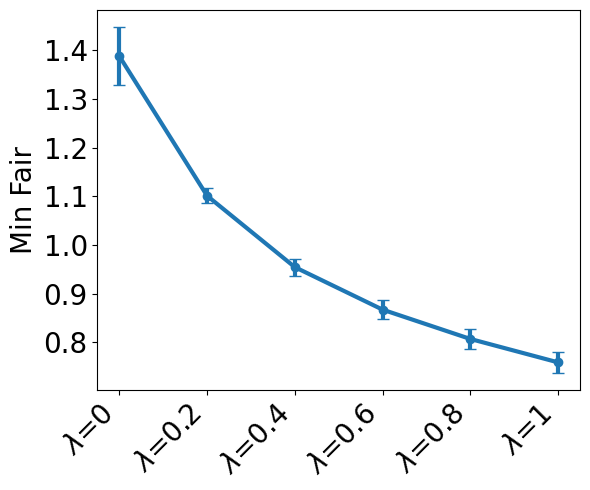

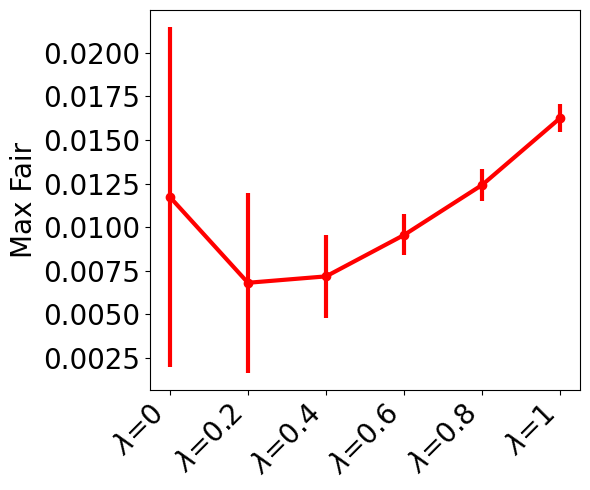

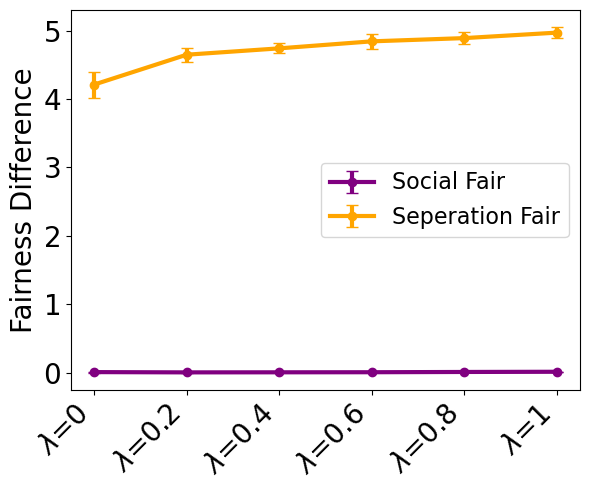

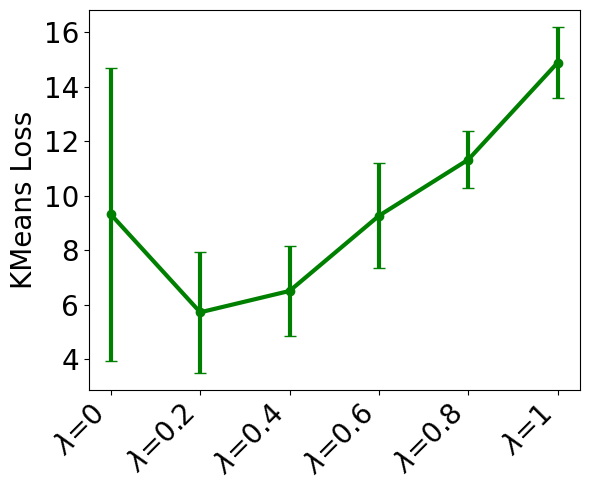

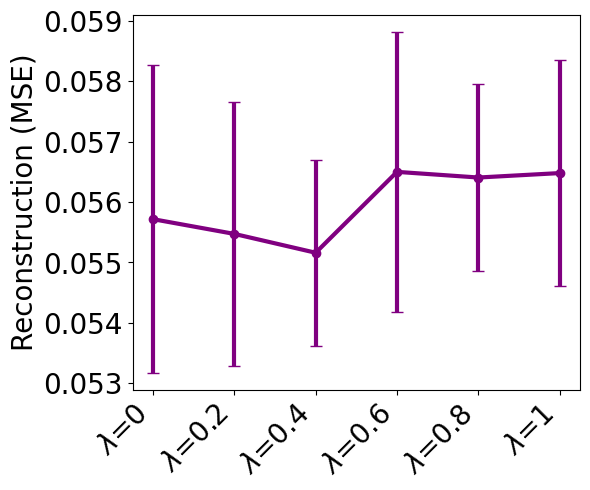

Plots saved in: ./plots


In [48]:


    
def plot_all_metrics_extended(min_fair_dict,
                              max_fair_dict,
                              social_fair_gap,
                              kmeans_costs_dict,
                              seperation_fair_gap,
                              rec_costs_dict=None,     # optional
                              cmp_costs_dict=None,     # optional
                              save_path="./plots"):
    
    """
    Plots mean ± std over seeds vs lambda in your exact style.
    Required: min_fair, fairness_gap, kmeans_costs dicts.
    Optional: reconstruction, compactness dicts (same structure).
    """
    def _to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            if len(x) and isinstance(x[0], torch.Tensor):
                return np.stack([t.detach().cpu().numpy() for t in x])
            return np.asarray(x, dtype=float)
        return np.asarray(x, dtype=float)

    def _get_mean_std(metric_dict, lambda_list):
        means, stds = [], []
        for lam in lambda_list:
            arr = _to_numpy(metric_dict[lam])
            means.append(float(np.mean(arr)) if arr.size else 0.0)
            stds.append(float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0)
        return means, stds
    
    def lam_label(l):
        s=f"{l:.2f}".rstrip('0').rstrip('.')
        return r'$\lambda$='+s
    
    lambda_list = sorted(min_fair_dict.keys())
    all_lams = sorted(lambda_list)
    tick_pos   = np.arange(1, 1 + len(all_lams))
    tick_labels = [lam_label(l) for l in all_lams]

    # ----- Min Fair -----
    min_fair_mean, min_fair_std = _get_mean_std(min_fair_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, min_fair_mean, yerr=min_fair_std, fmt='-o', capsize=4, linewidth=3)
    plt.ylabel('Min Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/min_fair_unified.pdf", dpi=300)
    plt.show()

    # ---------- Plot 2: social term (max(LA,LB)) ----------
    max_fair_mean, max_fair_std = _get_mean_std(max_fair_dict, lambda_list)

    plt.figure(figsize=(6,5))
    plt.errorbar(tick_pos, max_fair_mean, yerr=max_fair_std,
                 marker='o', linewidth=3, color='red')
    plt.ylabel('Max Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout(); 
    plt.savefig(f"{save_path}/max_fair_unified.pdf", dpi=300); 
    plt.show()


    # ----- Fairness Gap -----
    social_gap_mean, social_gap_std = _get_mean_std(social_fair_gap, lambda_list)
    seperation_gap_mean, seperation_gap_std = _get_mean_std(seperation_fair_gap, lambda_list)

    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, social_gap_mean, yerr=social_gap_std, fmt='-o', capsize=4, color='purple', linewidth=3, label='Social Fair')
    plt.errorbar(tick_pos, seperation_gap_mean, yerr=seperation_gap_std, fmt='-o', capsize=4, color='orange', linewidth=3, label='Seperation Fair')

    plt.ylabel('Fairness Difference', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.legend(fontsize=16); 
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/fairness_gap_unified.pdf", dpi=300)
    plt.show()

    # ----- KMeans Cost -----
    cost_mean, cost_std = _get_mean_std(kmeans_costs_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, cost_mean, yerr=cost_std, fmt='-o', capsize=4, color='green', linewidth=3)
    plt.ylabel('KMeans Loss', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/kmeans_cost_unified.pdf", dpi=300)
    plt.show()

    # ----- Reconstruction (optional) -----
    if rec_costs_dict is not None:
        rec_mean, rec_std = _get_mean_std(rec_costs_dict, lambda_list)
        plt.figure(figsize=(6, 5))
        plt.errorbar(tick_pos, rec_mean, yerr=rec_std, fmt='-o', capsize=4, color='purple', linewidth=3)
        plt.ylabel('Reconstruction (MSE)', fontsize=20)
        plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
        plt.yticks(fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{save_path}/reconstruction_unified.pdf", dpi=300)
        plt.show()

    print(f"Plots saved in: {save_path}")



# ===== Example usage with deep-run dicts =====
plot_all_metrics_extended(min_fair_dict,max_fair_dict,social_fair_gap, kmeans_costs,seperation_fair_gap,
                           rec_costs_dict=rec_costs, cmp_costs_dict=cmp_costs,
                           save_path="./plots")

